# MODELAGEM DE SCORE DE CRÉDITO: PREVISÃO DE INADIMPLÊNCIA

## Objetivo

O presente projeto visa prever a probabilidade de um cliente recorrente ser inadimplente em um novo pedido de crédito.

## Descrição do problema

A empresa **Digibank** tem tido sérios problemas com inadimplência na disponibilização de crédito aos seus clientes. A fim de evitar perdas significativas nesse serviço, a Digibank solicitou ao time Datarisk o desenvolvimento de um modelo preditivo capaz calcular a probabilidade de um cliente ser inadimplente em um novo pedido de crédito.

Para a resolução do problema foram disponibilizadas **3 bases de dados**, sendo elas:
1. **Base Cadastral:** contém informações estáticas dos clientes. Possui 8 features.<br>

| Variável | Descrição |
| :---: | :---: |
| ID_CLIENTE | Identificador único do cliente |
| DATA_CADASTRO | Data da realização do cadastro no sistema |
| DDD | Número do DDD do telefone do cliente |
| FLAG_PF | Indica se o cliente é uma pessoa física (‘X’) ou jurídica (‘NaN’) |
| SEGMENTO_INDUSTRIAL | Indica a qual segmento da indústria pertence o cliente |
| DOMINIO_EMAIL | Indica o domínio(ou provedor) do email utilizado para o cadastro |
| PORTE | Indica o porte (tamanho) da empresa |
| CEP_2_DIG | Indica os dois primeiros números do CEP do endereço cadastrado |

2. **Base Info:** contém informações adicionais dos clientes. Os dados variam mensalmente para cada cliente.

| Variável | Descrição |
| :---: | :---: |
| ID_CLIENTE | Identificador único do cliente |
| SAFRA_REF | Mês de referência da amostra |
| RENDA_MES_ANTERIOR | Renda ou faturamento declarado pelo cliente no fim do mês anterior |
| NO_FUNCIONARIOS | Número de funcionários reportado pelo cliente no fim do mês anterior |

3. **Base Pagamentos:** possui todas as transações passadas de empréstimos dos clientes.

| Variável | Descrição |
| :---: | :---: |
| ID_CLIENTE | Identificador único do cliente |
| SAFRA_REF | Mês de referência da amostra |
| DATA_EMISSAO_DOCUMENTO | Data da emissão da nota de crédito |
| DATA_VENCIMENTO | Data limite para pagamento do empréstimo |
| VALOR_A_PAGAR | Valor da nota de crédito |
| TAXA | Taxa de juros cobrada no empréstimo |
| DATA_PAGAMENTO | Data em que o cliente realizou o pagamento da nota(disponível apenas na base de desenvolvimento) |

4. **Variável Resposta:** É a inadimplência do cliente em cada transação. Serão consideradas **inadimplentes** as transações que possuírem uma diferença entre as datas de pagamento e vencimento maior ou igual a **5 dias**.

## Entregas do projeto

Como resultado deste projeto, será entregue uma base contendo as colunas **ID_CLIENTE**, **SAFRA_REF** e **INADIMPLENTE** com base nos dados do arquivo **base_pagamentos_teste.csv**.

# 0 - IMPORTS, HELPER FUNCTIONS E CARREGAMENTO DOS DADOS

## 0.1 - IMPORTS

In [237]:
import time
import pickle
import pandas                        as pd
import numpy                         as np

import matplotlib.pyplot             as plt
import seaborn                       as sns

from scipy                           import stats                     as ss

from sklearn                         import preprocessing             as pp
from sklearn.model_selection         import train_test_split, StratifiedKFold

from imblearn.under_sampling         import RandomUnderSampler

## 0.2 - Helper functions

Funções de ajuda que serão chamadas durante o desenvolvimento do problema.

In [150]:
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k =  cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n)/(min(kcorr-1, rcorr-1)))

## 0.3 - Carregamento dos dados

### 0.3.1 - Loading

In [151]:
# base_cadastral
df_bc = pd.read_csv('dataset/base_cadastral.csv')

# base_info
df_bi = pd.read_csv('dataset/base_info.csv')

# base_pagamentos_desenvolvimento
df_bpd = pd.read_csv('dataset/base_pagamentos_desenvolvimento.csv')

# base_pagamentos_teste
df_bpt = pd.read_csv('dataset/base_pagamentos_teste.csv')

### 0.3.2 - Merge dos datasets

In [152]:
# Merge df_raw e base_cadastral
df_raw = pd.merge(df_bpd, df_bc, how='left', on='ID_CLIENTE')

# Merge df_raw e base_info
df_raw = pd.merge(df_raw, df_bi, how='left', on=['ID_CLIENTE', 'SAFRA_REF'])

### 0.3.3 - Criação da variável resposta

In [153]:
# to_datetime
df_raw['DATA_PAGAMENTO'] = pd.to_datetime(df_raw['DATA_PAGAMENTO'])
df_raw['DATA_VENCIMENTO'] = pd.to_datetime(df_raw['DATA_VENCIMENTO'])

# Definição da variável resposta
df_raw['INADIMPLENTE'] = df_raw.loc[:, ['DATA_PAGAMENTO', 'DATA_VENCIMENTO']]\
                               .apply(lambda x: 1 if np.timedelta64((x['DATA_PAGAMENTO'] - x['DATA_VENCIMENTO']), 'D')  >= 5 else 
                                                0, axis=1)

### 0.3.4 - Nomes das features em snakecase

In [154]:
df_raw.columns = [x.lower() for x in list(df_raw.columns)]

# 1 - DESCRIÇÃO DOS DADOS

In [155]:
df1 = df_raw.copy()

## 1.1 - Dimensão dos dados

In [156]:
print('Número de linhas: {}'.format(df1.shape[0]))
print('Número de colunas: {}'.format(df1.shape[1]))

Número de linhas: 77414
Número de colunas: 17


## 1.2 - Checagem e transformação de data types

In [157]:
df1.dtypes

id_cliente                         int64
safra_ref                         object
data_emissao_documento            object
data_pagamento            datetime64[ns]
data_vencimento           datetime64[ns]
valor_a_pagar                    float64
taxa                             float64
data_cadastro                     object
ddd                               object
flag_pf                           object
segmento_industrial               object
dominio_email                     object
porte                             object
cep_2_dig                         object
renda_mes_anterior               float64
no_funcionarios                  float64
inadimplente                       int64
dtype: object

In [158]:
# Transformação dos dtypes
to_object_dict = {'id_cliente': 'str', 
                  'data_emissao_documento': 'datetime64[ns]', 
                  'data_cadastro': 'datetime64[ns]'}
df1 = df1.astype(to_object_dict)

In [159]:
df1.dtypes

id_cliente                        object
safra_ref                         object
data_emissao_documento    datetime64[ns]
data_pagamento            datetime64[ns]
data_vencimento           datetime64[ns]
valor_a_pagar                    float64
taxa                             float64
data_cadastro             datetime64[ns]
ddd                               object
flag_pf                           object
segmento_industrial               object
dominio_email                     object
porte                             object
cep_2_dig                         object
renda_mes_anterior               float64
no_funcionarios                  float64
inadimplente                       int64
dtype: object

## 1.3 - Checagem e substituição de NAs

In [160]:
df1.isna().sum()

id_cliente                    0
safra_ref                     0
data_emissao_documento        0
data_pagamento                0
data_vencimento               0
valor_a_pagar                 0
taxa                          0
data_cadastro                 0
ddd                        7414
flag_pf                   77195
segmento_industrial        1417
dominio_email               898
porte                      2476
cep_2_dig                     0
renda_mes_anterior         3937
no_funcionarios            3937
inadimplente                  0
dtype: int64

### 1.3.1 - Preenchendo os NAs

#### ddd

Os dados faltantes serão preenchidos com o valor de 'ddd' mais frequente para cada valor da feature 'cep_2_dig' (variável escolhida como referência por não conter nenhum valor nulo). Os valores de 'ddd' fora do padrão de 2 dígitos não serão modificados, pois não é possível identificar o segundo dígito.

In [161]:
df1['ddd'].unique()

array(['99', '31', '75', '49', '88', '18', '67', '21', '11', '44', nan,
       '19', '14', '16', '85', '41', '51', '12', '62', '43', '91', '42',
       '61', '33', '48', '71', '65', '38', '24', '(3', '47', '28', '(2',
       '81', '35', '13', '86', '94', '45', '17', '55', '64', '69', '32',
       '(6', '27', '66', '63', '46', '(1', '54', '77', '34', '74', '37',
       '53', '56', '95', '22', '73', '(9', '(4', '52', '87', '98', '(8',
       '92', '82', '79', '93', '83', '00', '(5', '15', '02', '84', '(0',
       '04', '07'], dtype=object)

In [162]:
# Groupby
aux = df1.loc[df1['ddd'].notnull(), ['ddd', 'cep_2_dig']].groupby(['cep_2_dig', 'ddd']).size().reset_index()
aux = aux.rename(columns={0: 'contagem_ddd'})

# Manter apenas os maiores valores de contagem_ddd por valor de 'cep_2_dig'
aux = aux.sort_values(['cep_2_dig', 'contagem_ddd'], ascending=(True, False))
aux = aux.drop_duplicates('cep_2_dig', keep='first')
aux = aux.rename(columns={'ddd': 'ddd_subs'})

# Merge com o dataset principal
df1 = pd.merge(df1, aux.loc[:, ['cep_2_dig', 'ddd_subs']], how='left', on='cep_2_dig')

# Preenchimentos dos NAs
df1['ddd'] = df1.loc[:, ['ddd', 'ddd_subs']].apply(lambda x: x['ddd_subs'] if pd.isnull(x['ddd']) else x['ddd'], axis=1)

# Preenchimento dos NAs que sobraram (8 linhas) com o ddd mais comum em todo o dataset
ddd_mais_comum = aux.sort_values('contagem_ddd', ascending=False)
ddd_mais_comum = ddd_mais_comum.iloc[0, 1]
df1['ddd'].fillna(ddd_mais_comum, inplace=True)

# Drop columns
df1 = df1.drop('ddd_subs', axis=1)

#### flag_pf

Como dito na seção **Descrição do problema**, os valores nulos devem ser considerados 'PJ'. Valores não nulos, 'PF'.

In [163]:
df1['flag_pf'] = df1.loc[:, 'flag_pf'].apply(lambda x: 'PF' if pd.notnull(x) else 'PJ')

#### segmento_industrial

Os dados faltantes serão substituídos pelo valor mais frequente de 'segmento_industrial' para cada valor único de 'cep_2_dig'.

In [164]:
# Groupby
aux = df1.loc[df1['segmento_industrial'].notnull(), ['segmento_industrial', 'cep_2_dig']].groupby(['cep_2_dig', 'segmento_industrial']).size().reset_index()
aux = aux.rename(columns={0: 'contagem_segmento_industrial'})

# Manter apenas os maiores valores de contagem_segmento_industrial por valor de 'cep_2_dig'
aux = aux.sort_values(['cep_2_dig', 'contagem_segmento_industrial'], ascending=(True, False))
aux = aux.drop_duplicates('cep_2_dig', keep='first')
aux = aux.rename(columns={'segmento_industrial': 'segmento_industrial_subs'})

# Merge com o dataset principal
df1 = pd.merge(df1, aux.loc[:, ['cep_2_dig', 'segmento_industrial_subs']], how='left', on='cep_2_dig')

# Preenchimentos dos NAs
df1['segmento_industrial'] = df1.loc[:, ['segmento_industrial', 'segmento_industrial_subs']]\
                                .apply(lambda x: x['segmento_industrial_subs'] if pd.isnull(x['segmento_industrial']) else x['segmento_industrial'], axis=1)

# Drop columns
df1 = df1.drop('segmento_industrial_subs', axis=1)

#### dominio_email

Os dados faltantes serão substituídos pelo valor mais frequente de 'dominio_email' para cada valor único de 'cep_2_dig'.

In [165]:
# groupby
aux = df1.loc[df1['dominio_email'].notnull(), ['dominio_email', 'cep_2_dig']].groupby(['cep_2_dig', 'dominio_email']).size().reset_index()
aux = aux.rename(columns={0: 'contagem_dominio_email'})

# Manter apenas os maiores valores de contagem_dominio_email por valor de 'cep_2_dig'
aux = aux.sort_values(['cep_2_dig', 'contagem_dominio_email'], ascending=(True, False))
aux = aux.drop_duplicates('cep_2_dig', keep='first')
aux = aux.rename(columns={'dominio_email': 'dominio_email_subs'})

# Merge com o dataset principal
df1 = pd.merge(df1, aux.loc[:, ['cep_2_dig', 'dominio_email_subs']], how='left', on='cep_2_dig')

# Preenchimentos dos NAs
df1['dominio_email'] = df1.loc[:, ['dominio_email', 'dominio_email_subs']]\
                          .apply(lambda x: x['dominio_email_subs'] if pd.isnull(x['dominio_email']) else x['dominio_email'], axis=1)

# Drop columns
df1 = df1.drop('dominio_email_subs', axis=1)

#### porte

Os dados faltantes serão substituídos pelo valor mais frequentente de 'porte' para cada valor único de 'cep_2_dig'.

In [166]:
# Groupby
aux = df1.loc[df1['porte'].notnull(), ['porte', 'cep_2_dig']].groupby(['cep_2_dig', 'porte']).size().reset_index()
aux = aux.rename(columns={0: 'contagem_porte'})

# Manter apenas os maiores valores de contagem_porte por valor de 'cep_2_dig'
aux = aux.sort_values(['cep_2_dig', 'contagem_porte'], ascending=(True, False))
aux = aux.drop_duplicates('cep_2_dig', keep='first')
aux = aux.rename(columns={'porte': 'porte_subs'})

# Merge com o dataset principal
df1 = pd.merge(df1, aux.loc[:, ['cep_2_dig', 'porte_subs']], how='left', on='cep_2_dig')

# Preenchimentos dos NAs
df1['porte'] = df1.loc[:, ['porte', 'porte_subs']].apply(lambda x: x['porte_subs'] if pd.isnull(x['porte']) else x['porte'], axis=1)

# Drop columns
df1 = df1.drop('porte_subs', axis=1)

#### renda_mes_anterior

Os valores nulos serão substituídos pelos valores dos **meses anteriores e posteriores** ao mês com dado faltante. Primeiramente, uma cópia da coluna renda_mes_anterior será criada (renda_mes_anterior_desloc). Esta será deslocada 1 linha para cima a cada iteração no loop for. Caso o valor em renda_mes_anterior seja nulo, este deve ser substituído pelo valor de renda_mes_anterior_desloc. Em seguida, o mesmo será feito deslocando a coluna 1 linha para baixo a cada iteração. Existem alguns casos em que o 'id_cliente' presente na **Base Pagamentos** não possui nenhum registro na tabela **Base Info**, permanecendo, assim, os valores nulos. Tais valores serão substituídos pelo valor médio de 'renda_mes_anterior' baseado nas features 'ddd', 'porte' e 'safra_ref'.

In [167]:
# Dataframe de trabalho
aux = df1.loc[:, ['id_cliente', 'safra_ref', 'renda_mes_anterior', 'porte', 'ddd']]
aux = aux.sort_values(['id_cliente', 'safra_ref'])
aux = aux.drop_duplicates(['id_cliente', 'safra_ref'], keep='first')

# Verificação de NAs
print('Quantidade de NAs: {}'.format(aux['renda_mes_anterior'].isna().sum()))

Quantidade de NAs: 2569


##### Deslocamento de linhas

In [168]:
# Deslocamento de linhas para cima
for i in range(1, 4, 1):
    aux['renda_mes_anterior_desloc'] = aux['renda_mes_anterior'].shift(-i)
    aux['id_cliente_desloc'] = aux['id_cliente'].shift(-i)
    aux['renda_mes_anterior'] = aux.loc[:, ['renda_mes_anterior', 'renda_mes_anterior_desloc', 'id_cliente', 'id_cliente_desloc']]\
                                   .apply(lambda x: x['renda_mes_anterior_desloc'] if (x['id_cliente']==x['id_cliente_desloc']) & (pd.isnull(x['renda_mes_anterior'])) else x['renda_mes_anterior'], axis=1)

# Deslocamento de linhas para baixo
for i in range(1, 4, 1):
    aux['renda_mes_anterior_desloc'] = aux['renda_mes_anterior'].shift(i)
    aux['id_cliente_desloc'] = aux['id_cliente'].shift(i)
    aux['renda_mes_anterior'] = aux.loc[:, ['renda_mes_anterior', 'renda_mes_anterior_desloc', 'id_cliente', 'id_cliente_desloc']]\
                                          .apply(lambda x: x['renda_mes_anterior_desloc'] if (x['id_cliente']==x['id_cliente_desloc']) & (pd.isnull(x['renda_mes_anterior'])) else x['renda_mes_anterior'], axis=1)

# Drop columns
aux = aux.drop(['renda_mes_anterior_desloc', 'id_cliente_desloc'], axis=1)

# Verificação de NAs
print('Quantidade de NAs: {}'.format(aux['renda_mes_anterior'].isna().sum()))

Quantidade de NAs: 80


##### Preenchimento de NAs por média das rendas baseadas nas features 'safra_ref', 'porte' e 'ddd'

In [169]:
# Preenchimento dos valores nulos que não foram preenchidos no processo anterior
## Dataframe de trabalho
auy = aux.loc[aux['renda_mes_anterior'].notnull(), ['safra_ref', 'porte', 'ddd', 'renda_mes_anterior']]\
         .groupby(['safra_ref', 'porte', 'ddd']).mean().reset_index()
auy = auy.rename(columns={'renda_mes_anterior': 'renda_mes_anterior_subs'})

## Merge
aux = pd.merge(aux, auy, how='left', on=['safra_ref', 'porte', 'ddd'])

## Preenchimento dos NAs
aux['renda_mes_anterior'] = aux.loc[:, ['renda_mes_anterior', 'renda_mes_anterior_subs']]\
                               .apply(lambda x: x['renda_mes_anterior_subs'] if pd.isnull(x['renda_mes_anterior']) else x['renda_mes_anterior'], axis=1)    

# Drop columns
aux = aux.drop('renda_mes_anterior_subs', axis=1)

# Verificação de NAs
print('Quantidade de NAs: {}'.format(aux['renda_mes_anterior'].isna().sum()))

Quantidade de NAs: 9


##### Preenchimento do restante de NAs por média das rendas baseadas na feature 'ddd'

In [170]:
# Preenchimento dos valores nulos que não foram preenchidos no processo anterior
# Dataframe de trabalho
auy = aux.loc[aux['renda_mes_anterior'].notnull(), ['ddd', 'renda_mes_anterior']].groupby(['ddd']).mean().reset_index()
auy = auy.rename(columns={'renda_mes_anterior': 'renda_mes_anterior_subs'})

## Merge
aux = pd.merge(aux, auy, how='left', on='ddd')

# Preenchimento dos NAs
aux['renda_mes_anterior'] = aux.loc[:, ['renda_mes_anterior', 'renda_mes_anterior_subs']]\
                               .apply(lambda x: x['renda_mes_anterior_subs'] if pd.isnull(x['renda_mes_anterior']) else x['renda_mes_anterior'], axis=1)    

# Drop columns
aux = aux.drop('renda_mes_anterior_subs', axis=1)

# Verificação de NAs
print('Quantidade de NAs: {}'.format(aux['renda_mes_anterior'].isna().sum()))

Quantidade de NAs: 0


##### Substituição no dataframe principal: df1

In [171]:
# Drop columns
aux = aux.drop(['ddd', 'porte'], axis=1)

# Rename columns
aux = aux.rename(columns={'renda_mes_anterior': 'renda_mes_anterior_subs'})

# Merge
df1 = pd.merge(df1, aux, how='left', on=['id_cliente', 'safra_ref'])

# Substituição dos NAs
df1['renda_mes_anterior'] = df1.loc[:, ['renda_mes_anterior', 'renda_mes_anterior_subs']]\
                               .apply(lambda x: x['renda_mes_anterior_subs'] if pd.isnull(x['renda_mes_anterior']) else 
                                                x['renda_mes_anterior'], axis=1)

# Drop columns
df1 = df1.drop('renda_mes_anterior_subs', axis=1)

#### no_funcionarios

Os valores nulos serão substituídos pelos valores dos **meses anteriores e posteriores** ao mês com dado faltante. Primeiramente, uma cópia da coluna 'no_funcionarios' será criada (no_funcionarios_desloc). Esta será deslocada 1 linha para cima a cada iteração no loop for. Caso o valor em no_funcionarios seja nulo, este deve ser substituído pelo valor de no_funcionarios_desloc. Em seguida, o mesmo será feito deslocando a coluna 1 linha para baixo a cada iteração. Existem alguns casos em que o 'id_cliente' presente na **Base Pagamentos** não possui nenhum registro na tabela **Base Info**, permanecendo, assim, os valores nulos. Tais valores serão substituídos pelo valor médio de 'no_funcionarios' baseado nas features 'ddd', 'porte' e 'safra_ref'.

In [172]:
# Dataframe de trabalho
aux = df1.loc[:, ['id_cliente', 'safra_ref', 'no_funcionarios', 'porte', 'ddd']]
aux = aux.sort_values(['id_cliente', 'safra_ref'])
aux = aux.drop_duplicates(['id_cliente', 'safra_ref'], keep='first')

# Verificação de NAs
print('Quantidade de NAs: {}'.format(aux['no_funcionarios'].isna().sum()))

Quantidade de NAs: 2569


##### Deslocamento de linhas

In [173]:
# Deslocamento de linhas para cima
for i in range(1, 4, 1):
    aux['no_funcionarios_desloc'] = aux['no_funcionarios'].shift(-i)
    aux['id_cliente_desloc'] = aux['id_cliente'].shift(-i)
    aux['no_funcionarios'] = aux.loc[:, ['no_funcionarios', 'no_funcionarios_desloc', 'id_cliente', 'id_cliente_desloc']]\
                                          .apply(lambda x: x['no_funcionarios_desloc'] if (x['id_cliente']==x['id_cliente_desloc']) & (pd.isnull(x['no_funcionarios'])) else x['no_funcionarios'], axis=1)

# Deslocamento de linhas para baixo
for i in range(1, 4, 1):
    aux['no_funcionarios_desloc'] = aux['no_funcionarios'].shift(i)
    aux['id_cliente_desloc'] = aux['id_cliente'].shift(i)
    aux['no_funcionarios'] = aux.loc[:, ['no_funcionarios', 'no_funcionarios_desloc', 'id_cliente', 'id_cliente_desloc']]\
                                          .apply(lambda x: x['no_funcionarios_desloc'] if (x['id_cliente']==x['id_cliente_desloc']) & (pd.isnull(x['no_funcionarios'])) else x['no_funcionarios'], axis=1)

# Drop columns
aux = aux.drop(['no_funcionarios_desloc', 'id_cliente_desloc'], axis=1)

# Verificação de NAs
print('Quantidade de NAs: {}'.format(aux['no_funcionarios'].isna().sum()))

Quantidade de NAs: 80


##### Preenchimento de NAs por média das rendas baseadas nas features 'safra_ref', 'porte' e 'ddd'

In [174]:
# Preenchimento dos valores nulos que não foram preenchidos no processo anterior
## Dataframe de trabalho
auy = aux.loc[aux['no_funcionarios'].notnull(), ['safra_ref', 'porte', 'ddd', 'no_funcionarios']]\
         .groupby(['safra_ref', 'porte', 'ddd']).mean().reset_index()
auy = auy.rename(columns={'no_funcionarios': 'no_funcionarios_subs'})

## Merge
aux = pd.merge(aux, auy, how='left', on=['safra_ref', 'porte', 'ddd'])

## Preenchimento dos NAs
aux['no_funcionarios'] = aux.loc[:, ['no_funcionarios', 'no_funcionarios_subs']]\
                               .apply(lambda x: x['no_funcionarios_subs'] if pd.isnull(x['no_funcionarios']) else x['no_funcionarios'], axis=1)    

# Drop columns
aux = aux.drop('no_funcionarios_subs', axis=1)

# Verificação de NAs
print('Quantidade de NAs: {}'.format(aux['no_funcionarios'].isna().sum()))

Quantidade de NAs: 9


##### Preenchimento do restante de NAs por média das rendas baseadas na feature 'ddd'

In [175]:
# Preenchimento dos valores nulos que não foram preenchidos no processo anterior
# Dataframe de trabalho
auy = aux.loc[aux['no_funcionarios'].notnull(), ['ddd', 'no_funcionarios']].groupby(['ddd']).mean().reset_index()
auy = auy.rename(columns={'no_funcionarios': 'no_funcionarios_subs'})

## Merge
aux = pd.merge(aux, auy, how='left', on='ddd')

# Preenchimento dos NAs
aux['no_funcionarios'] = aux.loc[:, ['no_funcionarios', 'no_funcionarios_subs']]\
                               .apply(lambda x: x['no_funcionarios_subs'] if pd.isnull(x['no_funcionarios']) else x['no_funcionarios'], axis=1)    

# Drop columns
aux = aux.drop('no_funcionarios_subs', axis=1)

# Verificação de NAs
print('Quantidade de NAs: {}'.format(aux['no_funcionarios'].isna().sum()))

Quantidade de NAs: 0


##### Substituição no dataframe principal: df1

In [176]:
# Drop columns
aux = aux.drop(['porte', 'ddd'], axis=1)

# Rename columns
aux = aux.rename(columns={'no_funcionarios': 'no_funcionarios_subs'})

# Merge
df1 = pd.merge(df1, aux, how='left', on=['id_cliente', 'safra_ref'])

# Substituição dos NAs
df1['no_funcionarios'] = df1.loc[:, ['no_funcionarios', 'no_funcionarios_subs']]\
                               .apply(lambda x: x['no_funcionarios_subs'] if pd.isnull(x['no_funcionarios']) else 
                                                x['no_funcionarios'], axis=1)

# Drop columns
df1 = df1.drop('no_funcionarios_subs', axis=1)

##### Problema gerado pela substituição de NAs em 'no_funcionarios' quando 'flag_pf' é igual a 'PF'
Uma avaliação dos dados mostra que quando a flag_pf é igual a 'PF', 'no_funcionarios' deve ser igual a 0. O código acima inseriu valores maiores que zero em alguns registros. Isso será corrigido agora.

C:\Users\faust\anaconda3\envs\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\faust\anaconda3\envs\venv\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


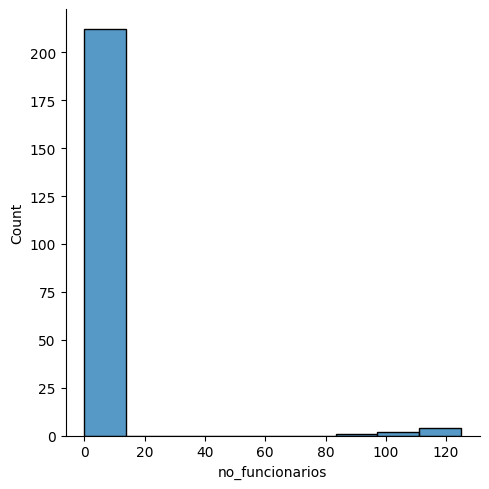

In [177]:
sns.displot(df1.loc[df1['flag_pf']=='PF', 'no_funcionarios']);

In [178]:
# Correção
df1.loc[(df1['flag_pf']=='PF') & (df1['no_funcionarios']>0), 'no_funcionarios'] = 0

### 1.3.2 - Recheck NA

In [179]:
df1.isna().sum()

id_cliente                0
safra_ref                 0
data_emissao_documento    0
data_pagamento            0
data_vencimento           0
valor_a_pagar             0
taxa                      0
data_cadastro             0
ddd                       0
flag_pf                   0
segmento_industrial       0
dominio_email             0
porte                     0
cep_2_dig                 0
renda_mes_anterior        0
no_funcionarios           0
inadimplente              0
dtype: int64

## 1.4 - Check do desbalanceamento dos dados

Observa-se um **alto desbalanceamento** nos dados.

In [180]:
df1['inadimplente'].value_counts()/df1.shape[0]

inadimplente
0    0.92978
1    0.07022
Name: count, dtype: float64

## 1.5 - Estatística descritiva

In [181]:
num_attributes = df1.select_dtypes(include=['float64', 'int64'])
cat_attributes = df1.select_dtypes(exclude=['float64', 'int64', 'datetime64[ns]'])

### 1.5.1 - Atributos numéricos

In [182]:
# Tendência central - média, mediana
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersão - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenação
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributos', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributos,min,max,range,mean,median,std,skew,kurtosis
0,valor_a_pagar,0.10,4400000.00,4399999.9,46565.460584,34751.35,46338.621737,16.283832,1153.263522
1,taxa,4.99,11.99,7.0,6.789623,5.99,1.798214,1.609800,2.233015
2,renda_mes_anterior,105.00,1682759.00,1682654.0,290595.466138,240302.00,212683.696117,1.379485,2.624621
3,no_funcionarios,0.00,198.00,198.0,117.484171,118.00,19.032203,-0.546730,3.385602
4,inadimplente,0.00,1.00,1.0,0.070220,0.00,0.255517,3.364067,9.317188


C:\Users\faust\AppData\Local\Temp\ipykernel_2616\279572014.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  num_attributes.hist(ax=ax, bins=50)





Observa-se nas distribuições a presença de outliers expressivos nas features valor_a_pagar e no_funcionarios. Estes casos serão avaliados mais a fundo.





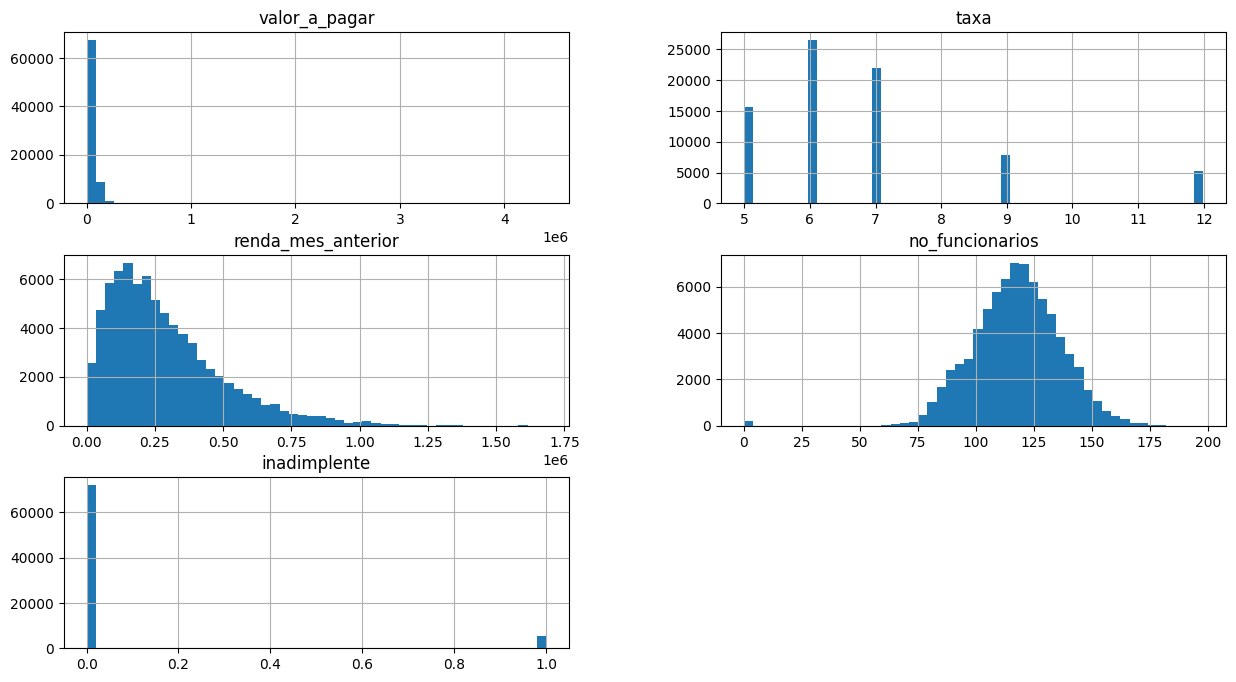

In [183]:
# Plot histograms
fig = plt.figure(figsize=(15, 8))
ax = fig.gca()
num_attributes.hist(ax=ax, bins=50)

print('\n\n\nObserva-se nas distribuições a presença de outliers expressivos nas features valor_a_pagar e no_funcionarios. Estes casos serão avaliados mais a fundo.\n\n\n')

#### Outliers na feature 'no_funcionarios'

Observa-se a presença de pontos isolados à esquerda. Possivelmente são **outliers**.

C:\Users\faust\anaconda3\envs\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


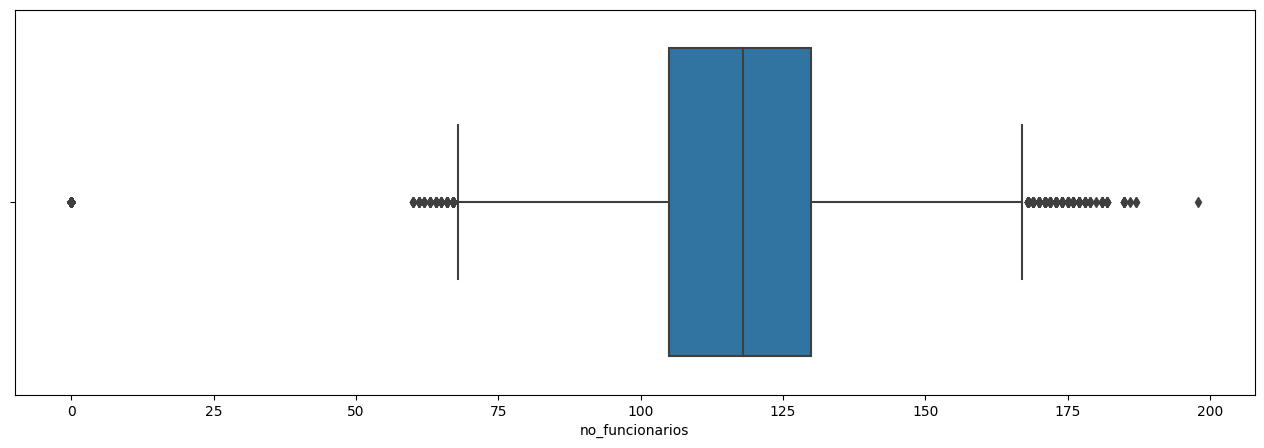

In [184]:
plt.figure(figsize=[16, 5])
sns.boxplot(x='no_funcionarios', data=df1);

In [185]:
# Identificando a quantidade de registros outliers e sua representatividade na base de dados
pontos_isolados = df1.loc[df1['no_funcionarios']==0, :]
print('Nº de registros isolados: {}'.format(pontos_isolados.shape[0]))
print('Representatividade no total de registros: {} %'.format(np.round(100*pontos_isolados.shape[0]/df1.shape[0], 2)))
pontos_isolados.head()

Nº de registros isolados: 219
Representatividade no total de registros: 0.28 %


,id_cliente,safra_ref,data_emissao_documento,data_pagamento,data_vencimento,valor_a_pagar,taxa,data_cadastro,ddd,flag_pf,segmento_industrial,dominio_email,porte,cep_2_dig,renda_mes_anterior,no_funcionarios,inadimplente
1683,5884104941462322372,2018-08,2018-08-29,2018-09-14,2018-09-14,5746.19,4.99,2018-01-07,65,PF,Serviços,GMAIL,GRANDE,78,121561.0,0.0,0
1718,6824842959463625344,2018-08,2018-08-29,2018-10-02,2018-10-04,3430.40,6.99,2015-10-15,27,PF,Comércio,GMAIL,GRANDE,29,11889.0,0.0,0
1862,7838728548369705327,2018-09,2018-09-04,2018-10-17,2018-10-10,5070.00,4.99,2013-09-22,63,PF,Serviços,GMAIL,GRANDE,77,22376.0,0.0,1
1863,7838728548369705327,2018-09,2018-09-09,2018-10-15,2018-10-15,87087.00,4.99,2013-09-22,63,PF,Serviços,GMAIL,GRANDE,77,22376.0,0.0,0
1952,1177363334134147131,2018-09,2018-09-14,2018-10-08,2018-10-08,28242.88,6.99,2015-02-08,65,PF,Serviços,YAHOO,GRANDE,78,28516.0,0.0,0


In [186]:
# Verificando a influência da variável 'flag_pf' nesses outliers
print('Valores únicos de flag_pf nos outliers: {}'.format(pontos_isolados['flag_pf'].unique()))
print('Valores únicos de flag_pf excluindo os outliers do dataset: {}'.format(df1.loc[df1['no_funcionarios']>25, 'flag_pf'].unique()))

Valores únicos de flag_pf nos outliers: ['PF']
Valores únicos de flag_pf excluindo os outliers do dataset: ['PJ']


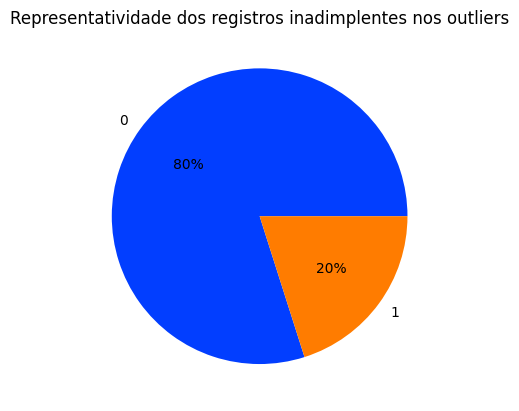

In [187]:
# Representatividade dos registros inadimplentes nesses outliers
pontos_isolados = pontos_isolados.loc[:, ['inadimplente']].groupby('inadimplente').size().reset_index()
pontos_isolados = pontos_isolados.rename(columns={0: 'contagem'})
palette_color = sns.color_palette('bright')
plt.pie(pontos_isolados['contagem'].to_list(), labels=pontos_isolados['inadimplente'].to_list(), colors=palette_color, autopct='%.0f%%')
plt.title('Representatividade dos registros inadimplentes nos outliers');

**CONCLUSÃO:** Os outliers são compostos unicamente por clientes com **'flag_pf'** igual a **'PF'**. Como dos 219 registros 44 são de inadimplentes (20%), foi decidido **não remover** esses outliers e avaliar o impacto disso no modelo de Machine Learning.

#### Outliers na feature 'valor_a_pagar'

Observa-se a presença de vários pontos isolados à direita no BoxPlot. Possivelmente são **outliers**.

C:\Users\faust\anaconda3\envs\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


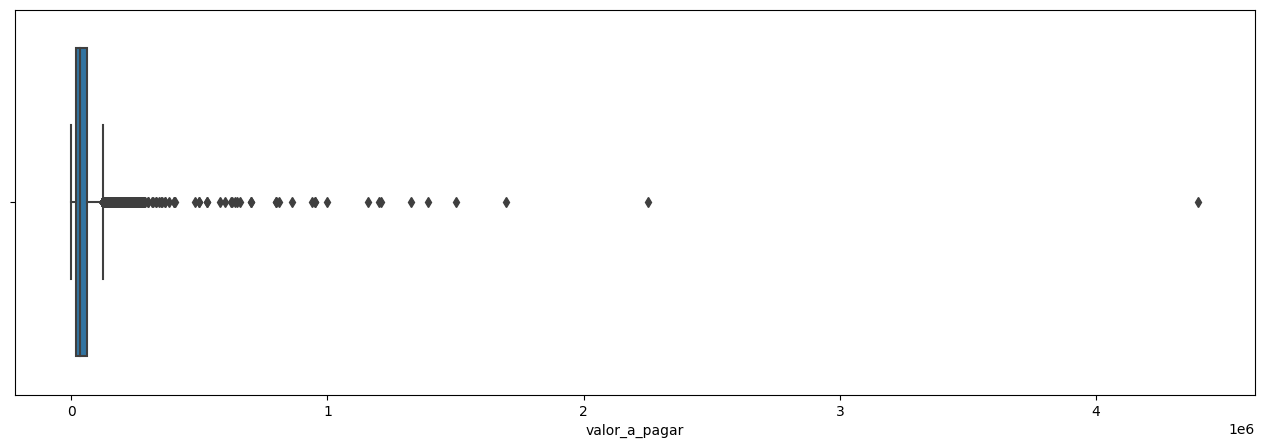

In [188]:
plt.figure(figsize=[16, 5])
sns.boxplot(x='valor_a_pagar', data=df1);

In [189]:
# Definindo o ponto de corte dos outliers pelo Percentile 99 (corte de 1% dos dados)
corte = np.percentile(df1['valor_a_pagar'], 99)
print('Ponto de corte na feature valor_a_pagar: {}'.format(corte))
numero_pontos_cortados = df1.loc[df1['valor_a_pagar']>=corte, 'valor_a_pagar'].shape[0]
print('Quantidade de registros cortados: {}'.format(numero_pontos_cortados))
lista_outliers = df1.loc[df1['valor_a_pagar']>=corte, 'inadimplente'].value_counts().to_list()
print('Representatividade dos registros inadimplentes nos outliers: {}'.format(lista_outliers[1]/lista_outliers[0]))

Ponto de corte na feature valor_a_pagar: 189156.13199999998
Quantidade de registros cortados: 775
Representatividade dos registros inadimplentes nos outliers: 0.06602475928473177


C:\Users\faust\anaconda3\envs\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


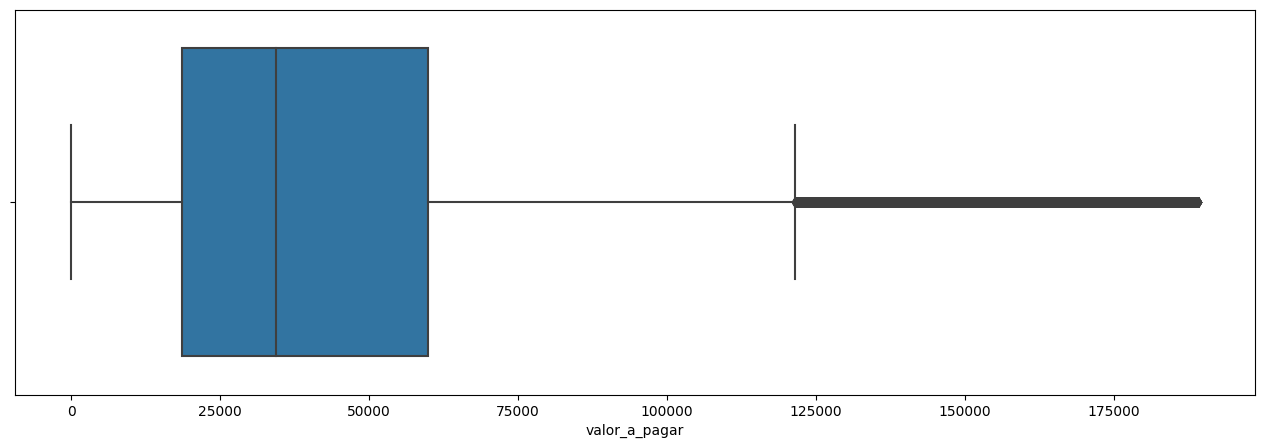

In [190]:
# BoxPlot após o corte de outliers
plt.figure(figsize=[16, 5])
sns.boxplot(x='valor_a_pagar', data=df1.loc[df1['valor_a_pagar']<corte, :]);

**CONCLUSÃO:** Os outliers têm forte presença na feature **'valor_a_pagar'** e a **representatividade** dos registros inadimplentes nos outliers é **baixa**. Decidiu-se cortar **1%** dos pontos da feature. Tal corte será de fato executado na **Seção 3**.

### 1.5.2 - Atributos categóricos

In [191]:
cat_attributes.describe()

,id_cliente,safra_ref,ddd,flag_pf,segmento_industrial,dominio_email,porte,cep_2_dig
count,77414,77414,77414,77414,77414,77414,77414,77414
unique,1248,35,78,2,3,6,3,90
top,6964108750473070287,2021-05,11,PJ,Serviços,YAHOO,MEDIO,13
freq,1151,2531,8972,77195,32400,25720,31330,3888


# 2 - FEATURE ENGINEERING

In [192]:
df2 = df1.copy()

In [193]:
# dif_dias_vencimento_emissao: Diferença entre as datas de vencimento e emissão do documento (tempo para pagar)
df2['dif_dias_vencimento_emissao'] = (df2['data_vencimento'] - df2['data_emissao_documento']).dt.days

# dias_cadastrado: Tempo de cadastro do cliente
max_date = df2['data_emissao_documento'].max()
df2['dias_cadastrado'] = (max_date - df2['data_cadastro']).dt.days

# renda_por_funcionario: clientes PF possuem 0 funcionários. Para evitar números infinitos neste cálculo, será considerado 1 funcionario para esses casos
df2['renda_por_funcionario'] = df2.loc[:, ['renda_mes_anterior', 'no_funcionarios']]\
                                  .apply(lambda x: x['renda_mes_anterior']/x['no_funcionarios'] if x['no_funcionarios']>0 else x['renda_mes_anterior']/1, axis=1)

# valor_a_pagar_com_taxa_por_renda: Valor a pagar + taxa dividido pela renda do mês anterior
df2['valor_a_pagar_com_taxa_por_renda'] = (1 + df2['taxa']/100)*df2['valor_a_pagar']/df2['renda_mes_anterior']

# proporcao_taxa_renda
df2['proporcao_taxa_renda'] = df2['taxa']/df2['renda_mes_anterior']

# proporcao_taxa_valor_a_pagar
df2['proporcao_taxa_valor_a_pagar'] = df2['taxa']/df2['valor_a_pagar']

# dia
df2['dia'] = df2['data_emissao_documento'].dt.day

# mes
df2['mes'] = df2['data_emissao_documento'].dt.month

# ano
df2['ano'] = df2['data_emissao_documento'].dt.year

# uf e regiao: Dados retirados de https://www.teleco.com.br/ncelddd.asp
## tabela_ddd
tabela_ddd = pd.DataFrame(
                           [['11', 'SP', 'Sudeste'],
                            ['12', 'SP', 'Sudeste'],
                            ['13', 'SP', 'Sudeste'],
                            ['14', 'SP', 'Sudeste'],
                            ['15', 'SP', 'Sudeste'],
                            ['16', 'SP', 'Sudeste'],
                            ['17', 'SP', 'Sudeste'],
                            ['18', 'SP', 'Sudeste'],
                            ['19', 'SP', 'Sudeste'],
                            ['21', 'RJ', 'Sudeste'],
                            ['22', 'RJ', 'Sudeste'],
                            ['24', 'RJ', 'Sudeste'],
                            ['27', 'ES', 'Sudeste'],
                            ['28', 'ES', 'Sudeste'],
                            ['31', 'MG', 'Sudeste'],
                            ['32', 'MG', 'Sudeste'],
                            ['33', 'MG', 'Sudeste'],
                            ['34', 'MG', 'Sudeste'],
                            ['35', 'MG', 'Sudeste'],
                            ['37', 'MG', 'Sudeste'],
                            ['38', 'MG', 'Sudeste'],
                            ['41', 'PR', 'Sul'],
                            ['42', 'PR', 'Sul'],
                            ['43', 'PR', 'Sul'],
                            ['44', 'PR', 'Sul'],
                            ['45', 'PR', 'Sul'],
                            ['46', 'PR', 'Sul'],
                            ['47', 'SC', 'Sul'],
                            ['48', 'SC', 'Sul'],
                            ['49', 'SC', 'Sul'],
                            ['51', 'RS', 'Sul'],
                            ['53', 'RS', 'Sul'],
                            ['54', 'RS', 'Sul'],
                            ['55', 'RS', 'Sul'],
                            ['61', 'DF', 'Centro-Oeste'],
                            ['62', 'GO', 'Centro-Oeste'],
                            ['63', 'TO', 'Norte'],
                            ['64', 'GO', 'Centro-Oeste'],
                            ['65', 'MT', 'Centro-Oeste'],
                            ['66', 'MT', 'Centro-Oeste'],
                            ['67', 'MS', 'Centro-Oeste'],
                            ['68', 'AC', 'Norte'],
                            ['69', 'RO', 'Norte'],
                            ['71', 'BA', 'Nordeste'],
                            ['73', 'BA', 'Nordeste'],
                            ['74', 'BA', 'Nordeste'],
                            ['75', 'BA', 'Nordeste'],
                            ['77', 'BA', 'Nordeste'],
                            ['79', 'SE', 'Nordeste'],
                            ['81', 'PE', 'Nordeste'],
                            ['82', 'AL', 'Nordeste'],
                            ['83', 'PB', 'Nordeste'],
                            ['84', 'RN', 'Nordeste'],
                            ['85', 'CE', 'Nordeste'],
                            ['86', 'PI', 'Nordeste'],
                            ['87', 'PE', 'Nordeste'],
                            ['88', 'CE', 'Nordeste'],
                            ['89', 'PI', 'Nordeste'],
                            ['91', 'PA', 'Norte'],
                            ['92', 'AM', 'Norte'],
                            ['93', 'PA', 'Norte'],
                            ['94', 'PA', 'Norte'],
                            ['95', 'RR', 'Norte'],
                            ['96', 'AP', 'Norte'],
                            ['97', 'AM', 'Norte'],
                            ['98', 'MA', 'Nordeste'],
                            ['99', 'MA', 'Nordeste']],
                            columns=['ddd', 'uf', 'regiao'])

## Merge
df2 = pd.merge(df2, tabela_ddd, how='left', on='ddd')
df2['uf'].fillna('Indefinido', inplace=True)
df2['regiao'].fillna('Indefinido', inplace=True)

In [194]:
df2.isna().sum()

id_cliente                          0
safra_ref                           0
data_emissao_documento              0
data_pagamento                      0
data_vencimento                     0
valor_a_pagar                       0
taxa                                0
data_cadastro                       0
ddd                                 0
flag_pf                             0
segmento_industrial                 0
dominio_email                       0
porte                               0
cep_2_dig                           0
renda_mes_anterior                  0
no_funcionarios                     0
inadimplente                        0
dif_dias_vencimento_emissao         0
dias_cadastrado                     0
renda_por_funcionario               0
valor_a_pagar_com_taxa_por_renda    0
proporcao_taxa_renda                0
proporcao_taxa_valor_a_pagar        0
dia                                 0
mes                                 0
ano                                 0
uf          

# 3 - FILTRAGEM DOS DADOS

In [195]:
df3 = df2.copy()

## 3.1 - Avaliação de outliers nas features geradas na seção 2

A avaliação consistirá na **análise do histograma** das features criadas.

C:\Users\faust\AppData\Local\Temp\ipykernel_2616\1246150801.py:7: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df3.loc[:, cols_created].hist(ax=ax, bins=50);


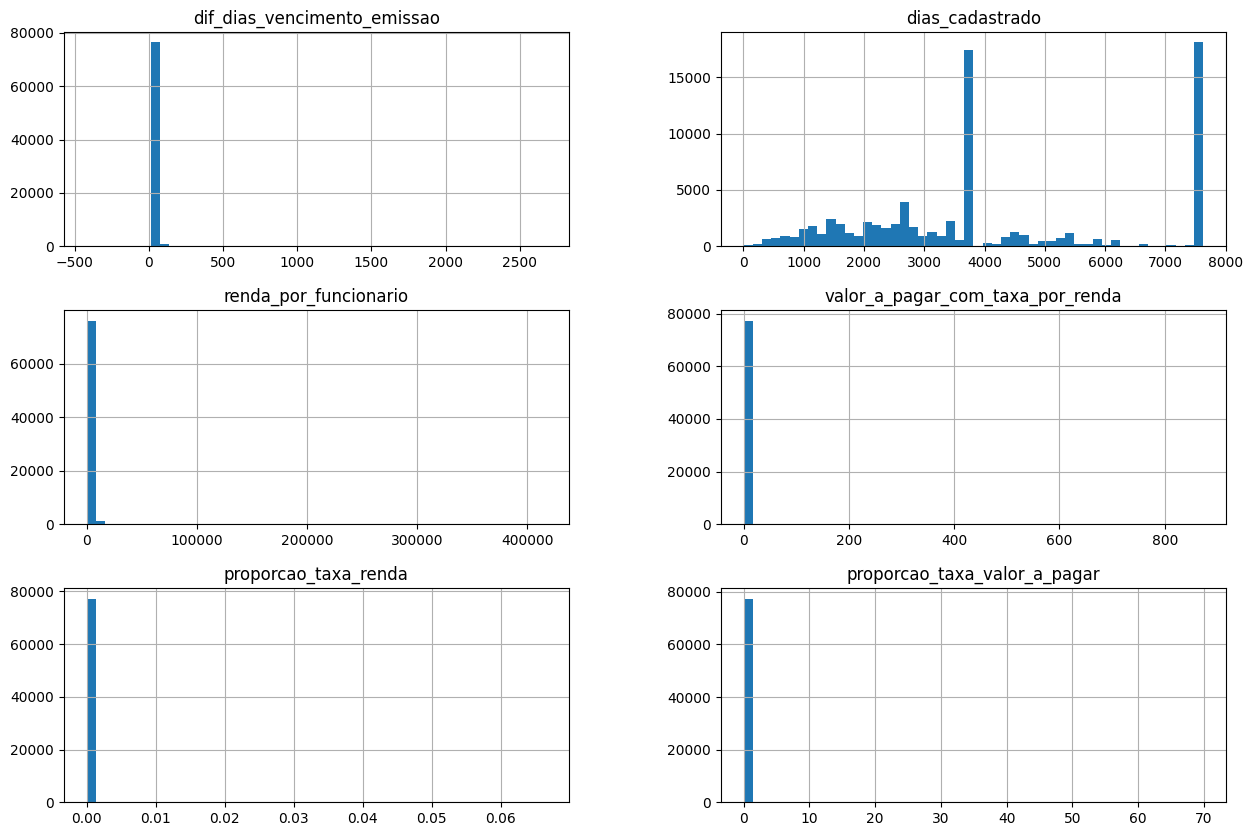

In [196]:
# Plotando os histogramas
cols_created = ['dif_dias_vencimento_emissao', 'dias_cadastrado', 'renda_por_funcionario', 'valor_a_pagar_com_taxa_por_renda', 
                'proporcao_taxa_renda', 'proporcao_taxa_valor_a_pagar']
# Plot histogramas
fig = plt.figure(figsize=(15, 10))
ax = fig.gca()
df3.loc[:, cols_created].hist(ax=ax, bins=50);

-----------------------------------

**ANÁLISE** 
1. Como se observa, a maioria das variáveis possuem **longas caudas à direita** (a feature 'dif_dias_vencimento_emissao' também possui cauda à esquerda), exceto a feature 'dias_cadastrado' que, apesar dos 2 picos, aparentemente não possui outliers. 
2. Serão considerados como outliers os pontos após o percentil 99 (1% dos dados). É feita uma avaliação da **representatividade dos registros inadimplentes** nos outliers.

------------------------

In [197]:
# Construção de dataframe para observação da representatividades dos registros inadimplentes nos outliers
lista_outliers = []
for i in cols_created:
    corte = np.percentile(df3[i], 99)
    lista = df3.loc[df3[i]>=corte, 'inadimplente'].value_counts().to_list()
    lista.append(lista[1]/lista[0])
    lista.append(i)
    lista_outliers.append(lista)
    
lista_outliers = pd.DataFrame(lista_outliers, columns=['total_registros', 'total_registros_inadimplentes', 'representatividade_outliers', 'feature'])
lista_outliers.loc[:, ['feature', 'total_registros', 'total_registros_inadimplentes', 'representatividade_outliers']]

,feature,total_registros,total_registros_inadimplentes,representatividade_outliers
0,dif_dias_vencimento_emissao,632,151,0.238924
1,dias_cadastrado,17047,1043,0.061184
2,renda_por_funcionario,716,59,0.082402
3,valor_a_pagar_com_taxa_por_renda,608,167,0.274671
4,proporcao_taxa_renda,490,285,0.581633
5,proporcao_taxa_valor_a_pagar,524,259,0.494275


-----------------------------------

**CONCLUSÃO** 
1. A **presença** de registro de inadimplentes nos outliers é **significativa** na maioria das variáveis, logo, isso **inviabiliza a exclusão** desses pontos do dataset de trabalho, pois podem ser **importantes** para a modelagem da solução.
2. Apesar da baixa representatividade dos inadimplentes nas variáveis 'dias_cadastrado' e 'renda_por_funcionario', foi decidido manter os outliers no dataset de trabalho, pois aparentam não prejudicar a modelagem a ser construída.

------------------------

## 3.2 - Seleção de linhas

Como mencionado na **Seção 1.5.1**, o corte de dados será em **'valor_a_pagar' = 189156.13199999998**.

In [198]:
# Remoção de outliers de 'valor_a_pagar'
corte = np.percentile(df1['valor_a_pagar'], 99)
df3 = df3.loc[df3['valor_a_pagar'] < corte, :]

## 3.3 - Seleção de colunas

In [199]:
df3 = df3.drop(['data_emissao_documento', 'data_pagamento', 'data_vencimento', 'data_cadastro'], axis=1)

# 4 - ANÁLISE EXPLORATÓRIA DE DADOS

In [200]:
df4 = df2.copy()

# Remoção de outliers de 'valor_a_pagar'
corte = np.percentile(df2['valor_a_pagar'], 99)
df4 = df4.loc[df4['valor_a_pagar'] < corte, :]

## 4.1 - Análise univariada

### 4.1.1 - Atributos numéricos

C:\Users\faust\AppData\Local\Temp\ipykernel_2616\2548284350.py:6: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  num_attributes.hist(ax=ax, bins=50);


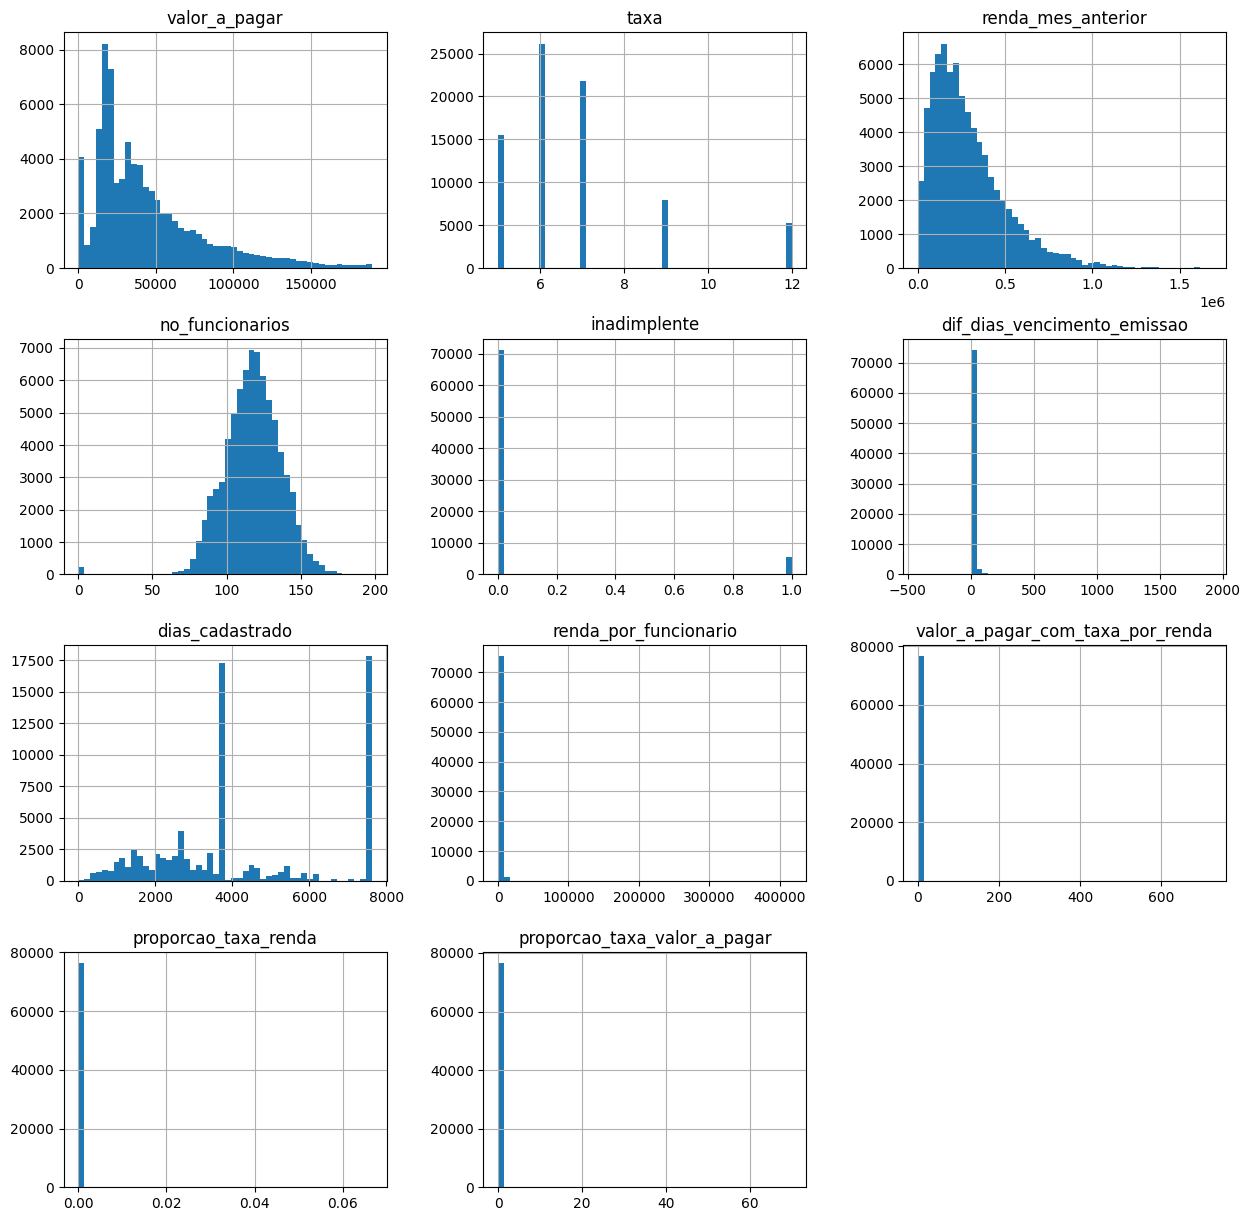

In [201]:
num_attributes = df4.select_dtypes(include=['int64', 'float64'])

# Plot histogramas
fig = plt.figure(figsize=(15,15))
ax = fig.gca()
num_attributes.hist(ax=ax, bins=50);

### 4.1.2 - Atributos categóricos

#### Representatividade: flag_pf, segmento_industrial, dominio_email e porte

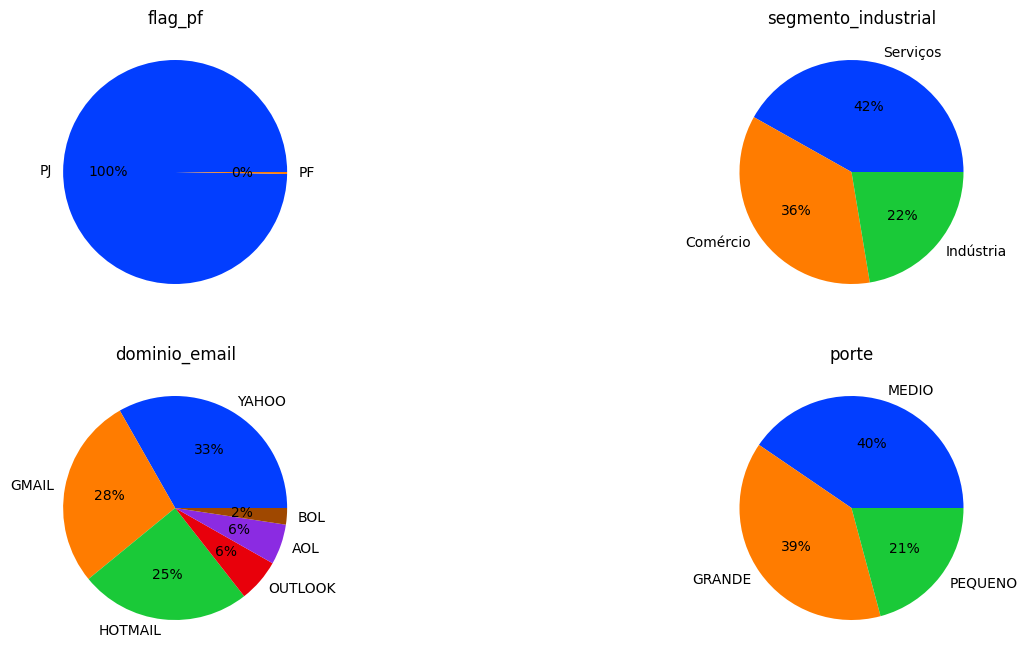

In [202]:
# Colunas selecionadas para representação gráfica
cols_selected = ['flag_pf', 'segmento_industrial', 'dominio_email', 'porte']

plt.figure(figsize=[16, 8])
palette_color = sns.color_palette('bright')
j = 1
for i in cols_selected:
    # Data Frame
    aux = pd.DataFrame(cat_attributes[i].value_counts().reset_index())
    aux.columns = [i, 'counts']
    
    #plot
    plt.subplot(2, 2, j)
    plt.pie(aux['counts'].to_list(), labels=aux[i].to_list(), colors=palette_color, autopct='%.0f%%')
    plt.title(i)
    j = j + 1

plt.show()

#### Variáveis ddd e cep_2_dig

C:\Users\faust\anaconda3\envs\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\faust\anaconda3\envs\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\faust\anaconda3\envs\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\faust\anaconda3\envs\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Categorica

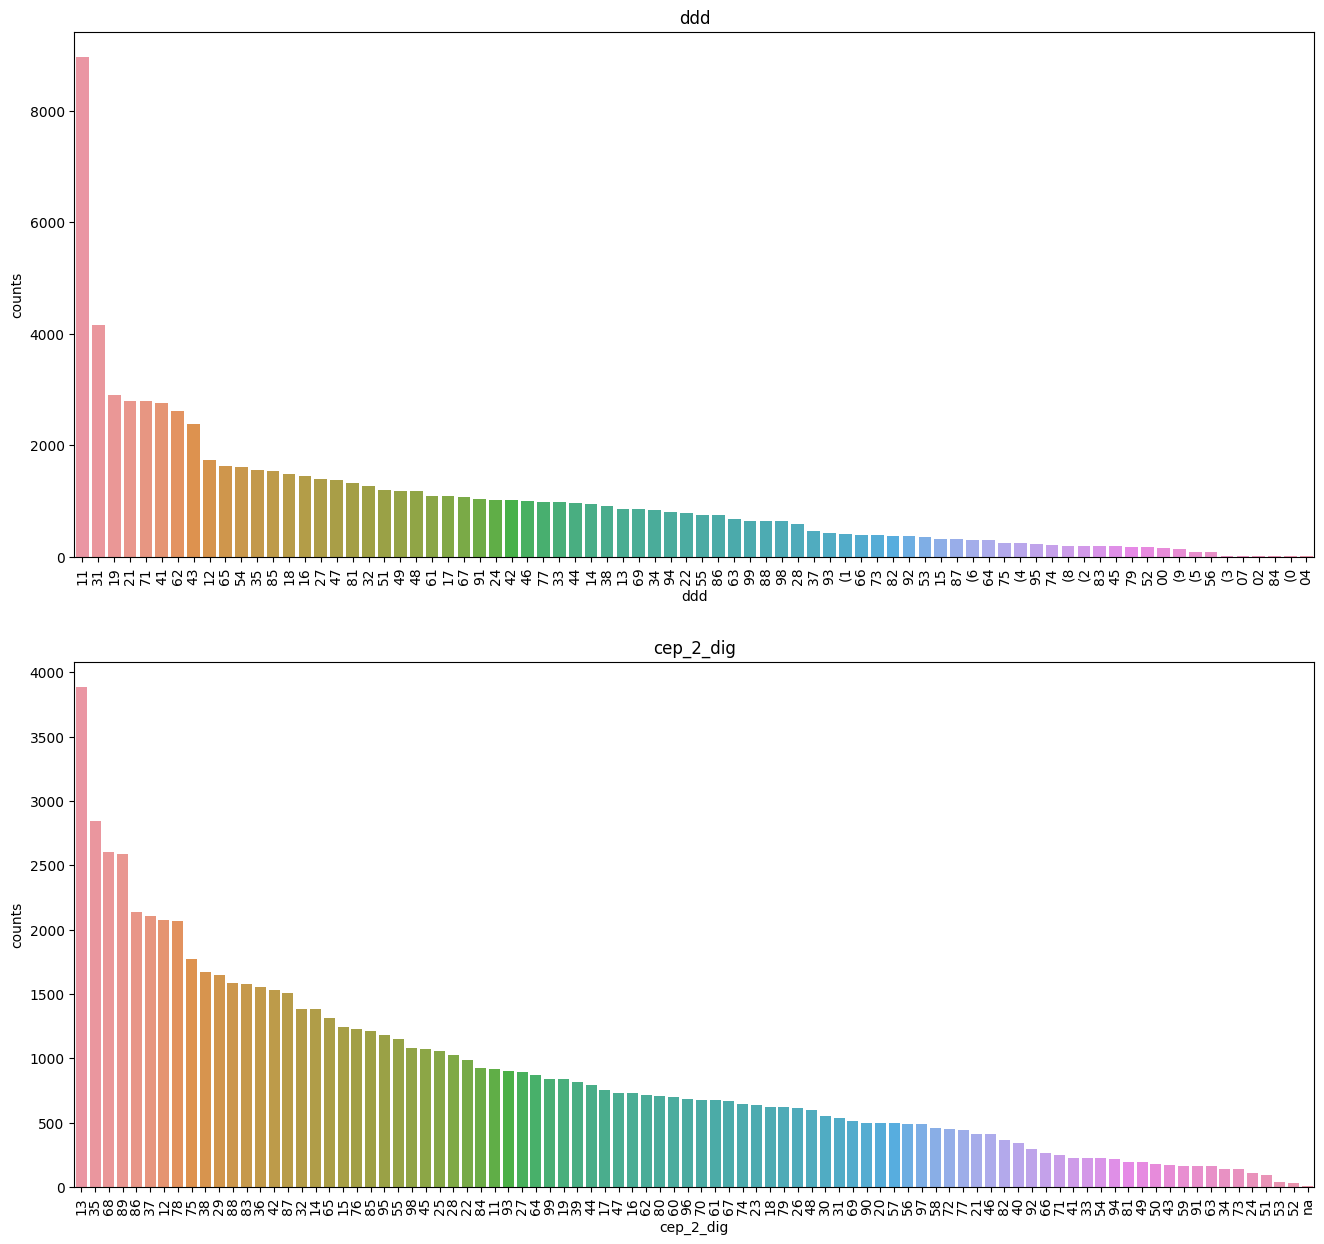

In [203]:
# Colunas selecionadas para representação gráfica
cols_selected = ['ddd', 'cep_2_dig']

plt.figure(figsize=[16, 15])
j = 1
for i in cols_selected:
    # Data Frame
    aux = pd.DataFrame(cat_attributes[i].value_counts().reset_index())
    aux.columns = [i, 'counts']
    
    #plot
    plt.subplot(2, 1, j)
    sns.barplot(x=i, y='counts', data=aux)
    plt.xticks(rotation=90)
    plt.title(i)
    j = j + 1

## 4.2 - Análise bivariada

**COMO SERÁ FEITO:** A análise bivariada é realizada através da confirmação de **HIPÓTESES DO NEGÓCIO**.

### 1. Mais de 40% dos pedidos de crédito inadimplentes estão na região Sudeste.

**FALSO** Menos de 40% dos inadimplentes estão na região Sudeste.

C:\Users\faust\anaconda3\envs\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\faust\anaconda3\envs\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\faust\anaconda3\envs\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


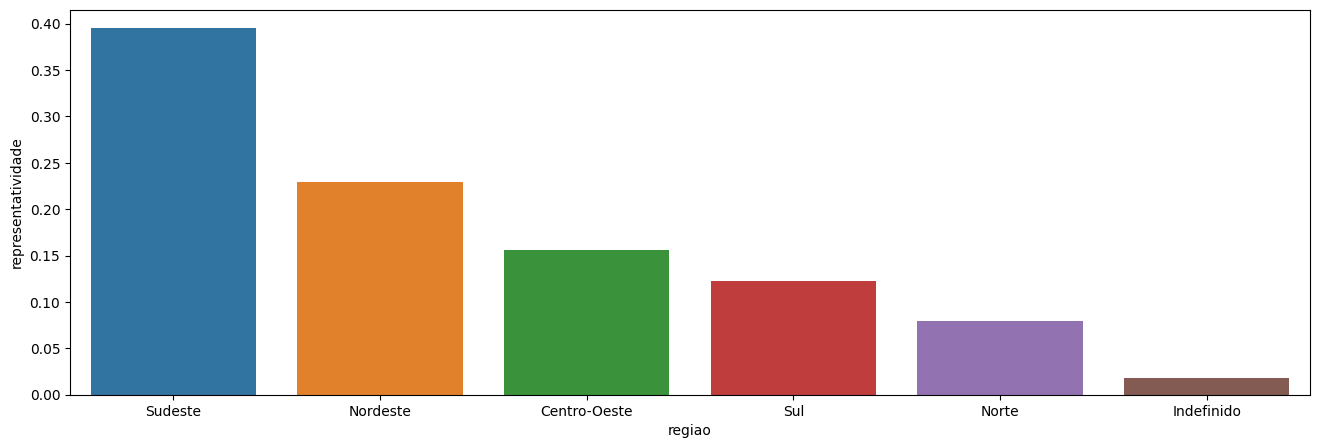

In [204]:
# Dataframe
aux = df4.loc[df4['inadimplente']==1, ['regiao', 'inadimplente']]
aux = aux.groupby('regiao').sum().reset_index()
total_inadimplentes = aux['inadimplente'].sum()
aux['representatividade'] = aux['inadimplente']/total_inadimplentes
aux = aux.sort_values('representatividade', ascending=False)

# Plot
plt.figure(figsize=[16, 5])
sns.barplot(x='regiao', y='representatividade', data=aux);

### 2. A região Sul é a que possui a menor representatividade de pedidos de crédito inadimplentes.

**VERDADEIRO** A menor taxa de transações inadimplentes é da região Sul.

C:\Users\faust\anaconda3\envs\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\faust\anaconda3\envs\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\faust\anaconda3\envs\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


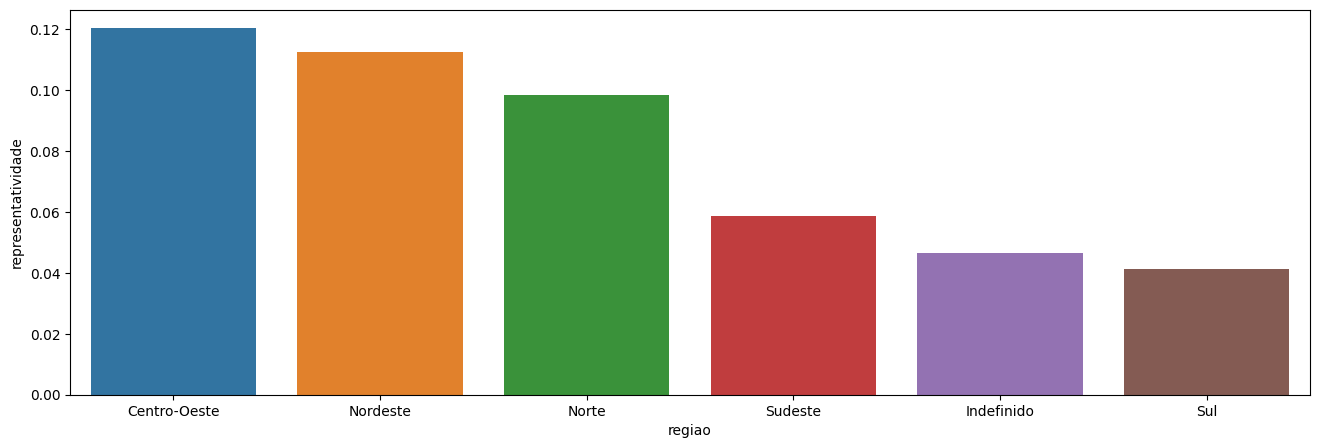

In [205]:
# Dataframe
aux = df4.loc[df4['inadimplente']==1, ['regiao', 'inadimplente']]
aux = aux.groupby('regiao').sum().reset_index()
aux2 = df4.loc[:, ['regiao']]
aux2 = aux2.groupby('regiao').size().reset_index()
aux2 = aux2.rename(columns={0: 'total_transacoes'})
aux = pd.merge(aux, aux2, how='left', on='regiao')
aux['representatividade'] = aux['inadimplente']/aux['total_transacoes']
aux = aux.sort_values('representatividade', ascending=False)

# Plot
plt.figure(figsize=[16, 5])
sns.barplot(x='regiao', y='representatividade', data=aux);

### 3. São Paulo possui mais de 20% dos pedidos de crédito inadimplentes.

**VERDADEIRO** Mais de 20% dos inadimplentes estão no estado de São Paulo.

C:\Users\faust\anaconda3\envs\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\faust\anaconda3\envs\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\faust\anaconda3\envs\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


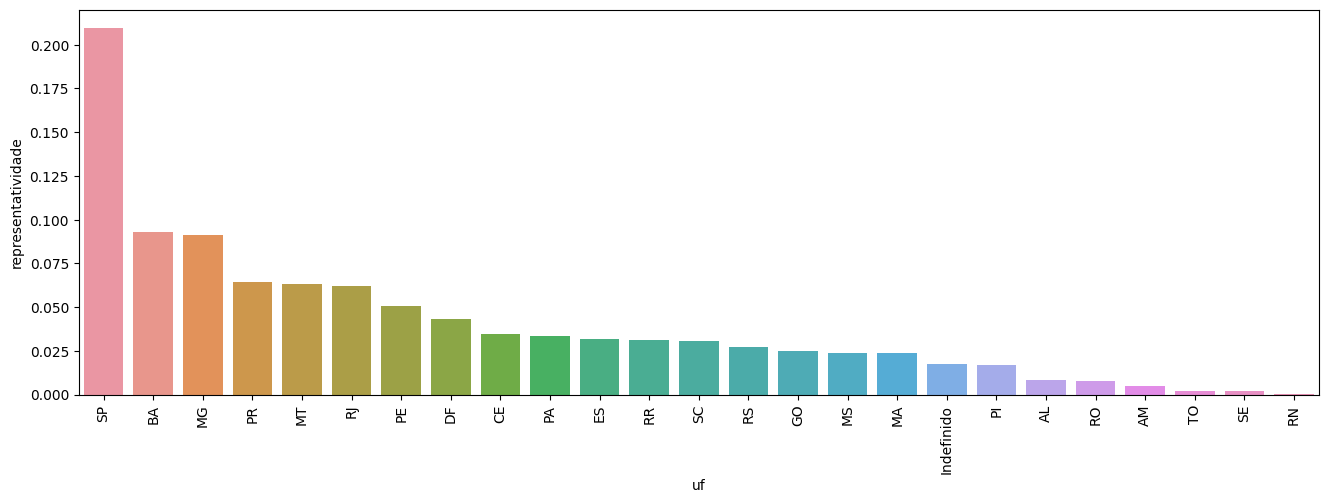

In [206]:
# Dataframe
aux = df4.loc[df4['inadimplente']==1, ['uf', 'inadimplente']]
aux = aux.groupby('uf').sum().reset_index()
total_inadimplentes = aux['inadimplente'].sum()
aux['representatividade'] = aux['inadimplente']/total_inadimplentes
aux = aux.sort_values('representatividade', ascending=False)

# Plot
plt.figure(figsize=[16, 5])
sns.barplot(x='uf', y='representatividade', data=aux)
plt.xticks(rotation=90);

### 4. A região do Sudeste detém mais de 40% dos clientes que já foram inadimplentes alguma vez no histórico.

**VERDADEIRO** A região sudeste possui mais de 40% dos clientes inadimplentes no histórico de dados.

C:\Users\faust\anaconda3\envs\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\faust\anaconda3\envs\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\faust\anaconda3\envs\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


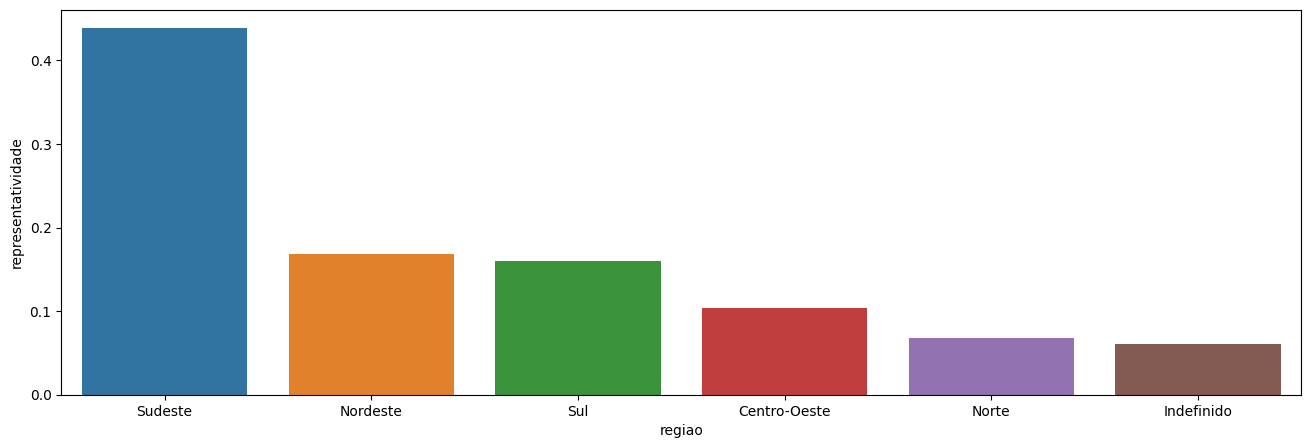

In [207]:
# Dataframe
aux = df4.loc[df4['inadimplente']==1, ['id_cliente', 'regiao']]
aux = aux.drop_duplicates('id_cliente')
total_clientes_inadimplentes = aux.shape[0]
aux = aux.groupby('regiao').size().reset_index()
aux = aux.rename(columns={0: 'inadimplente'})
aux['representatividade'] = aux['inadimplente']/total_clientes_inadimplentes
aux = aux.sort_values('representatividade', ascending=False)

# Plot
plt.figure(figsize=[16, 5])
sns.barplot(x='regiao', y='representatividade', data=aux);

### 5. O estado de São Paulo detém mais de 40% dos clientes que já foram inadimplentes alguma vez no histórico.

**FALSO** A região sudeste detém menos de 40% dos clientes inadimplentes no histórico de dados.

C:\Users\faust\anaconda3\envs\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\faust\anaconda3\envs\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\faust\anaconda3\envs\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


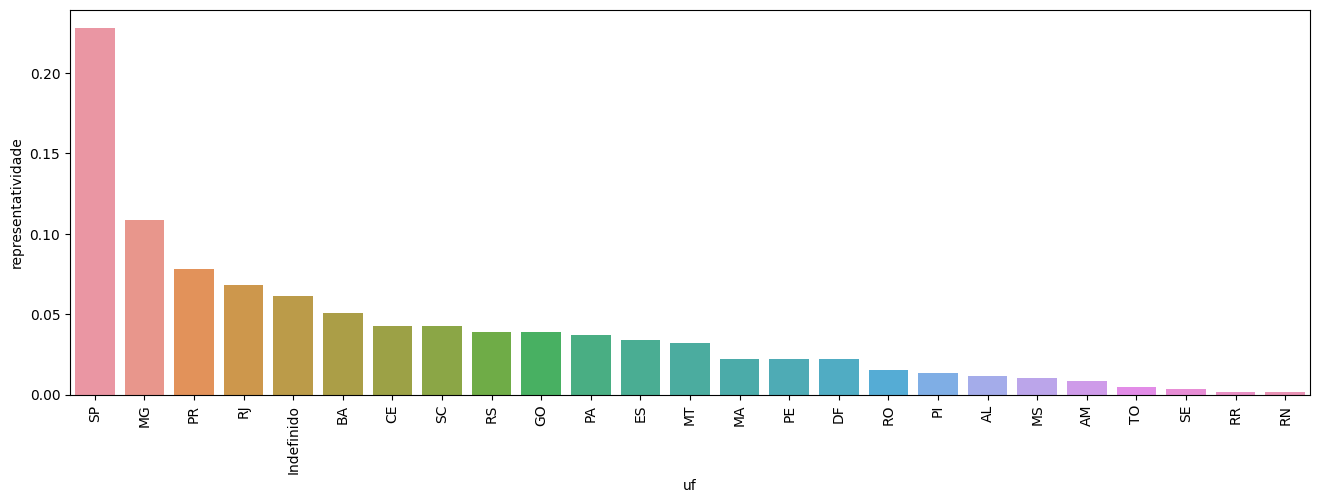

In [208]:
# Dataframe
aux = df4.loc[df4['inadimplente']==1, ['id_cliente', 'uf']]
aux = aux.drop_duplicates('id_cliente')
total_clientes_inadimplentes = aux.shape[0]
aux = aux.groupby('uf').size().reset_index()
aux = aux.rename(columns={0: 'inadimplente'})
aux['representatividade'] = aux['inadimplente']/total_clientes_inadimplentes
aux = aux.sort_values('representatividade', ascending=False)

# Plot
plt.figure(figsize=[16, 5])
sns.barplot(x='uf', y='representatividade', data=aux)
plt.xticks(rotation=90);

### 6. Empresas de porte menor possuem mais pedidos de crédito inadimplentes.

**FALSO** As empresas de pequeno são as que têm menos pedidos de crédito inadimplentes. As médio porte possuem a maior taxa.

C:\Users\faust\anaconda3\envs\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\faust\anaconda3\envs\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\faust\anaconda3\envs\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


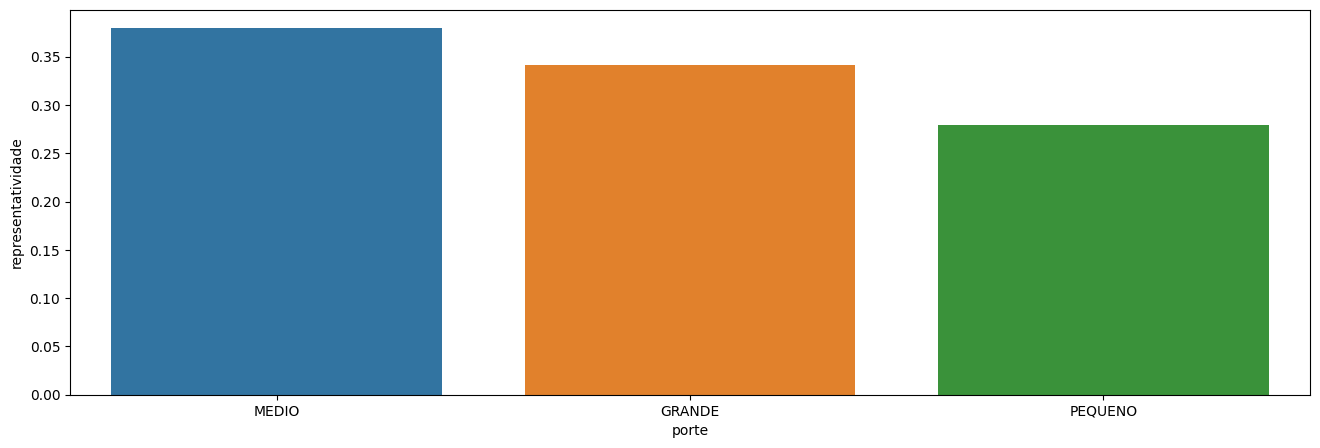

In [209]:
# Dataframe
aux = df4.loc[df4['inadimplente']==1, ['porte', 'inadimplente']]
aux = aux.groupby('porte').sum().reset_index()
total_inadimplentes = aux['inadimplente'].sum()
aux['representatividade'] = aux['inadimplente']/total_inadimplentes
aux = aux.sort_values('representatividade', ascending=False)

# Plot
plt.figure(figsize=[16, 5])
sns.barplot(x='porte', y='representatividade', data=aux);

### 7. Empresas do segmento Comércio possuem mais pedidos de crédito inadimplentes.

**FALSO** As empresas do segmento Comércio são as que têm menos pedidos de crédito inadimplentes. As do segmento Serviços possuem a maior taxa.

C:\Users\faust\anaconda3\envs\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\faust\anaconda3\envs\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\faust\anaconda3\envs\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


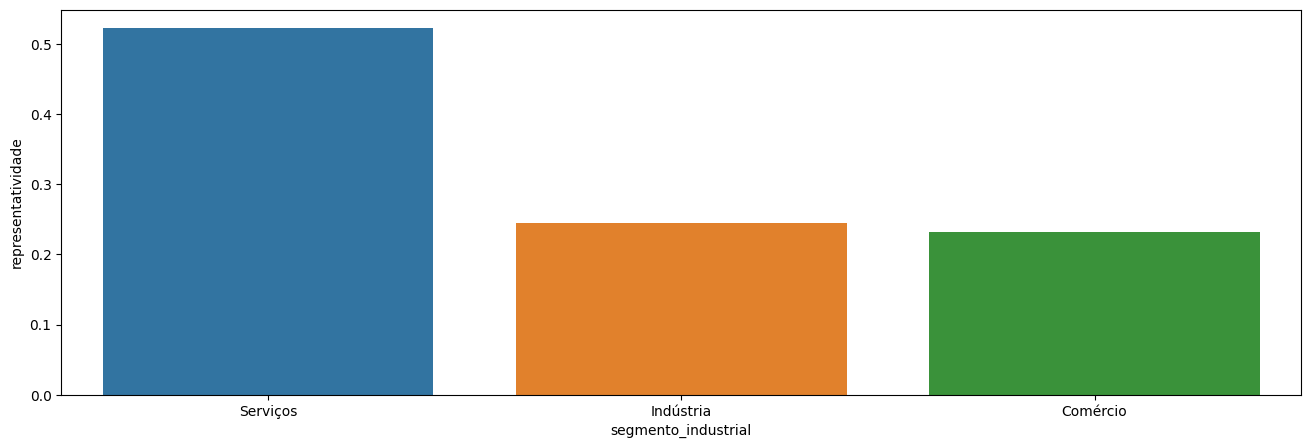

In [210]:
# Dataframe
aux = df4.loc[df4['inadimplente']==1, ['segmento_industrial', 'inadimplente']]
aux = aux.groupby('segmento_industrial').sum().reset_index()
total_inadimplentes = aux['inadimplente'].sum()
aux['representatividade'] = aux['inadimplente']/total_inadimplentes
aux = aux.sort_values('representatividade', ascending=False)

# Plot
plt.figure(figsize=[16, 5])
sns.barplot(x='segmento_industrial', y='representatividade', data=aux);

### 8. Clientes mais antigos possuem taxa de inadimplência menor

**FALSO** Não há correlação entre os dias cadastrado do cliente e sua taxa de inadimplência, como mostra n gráfico heatmap.

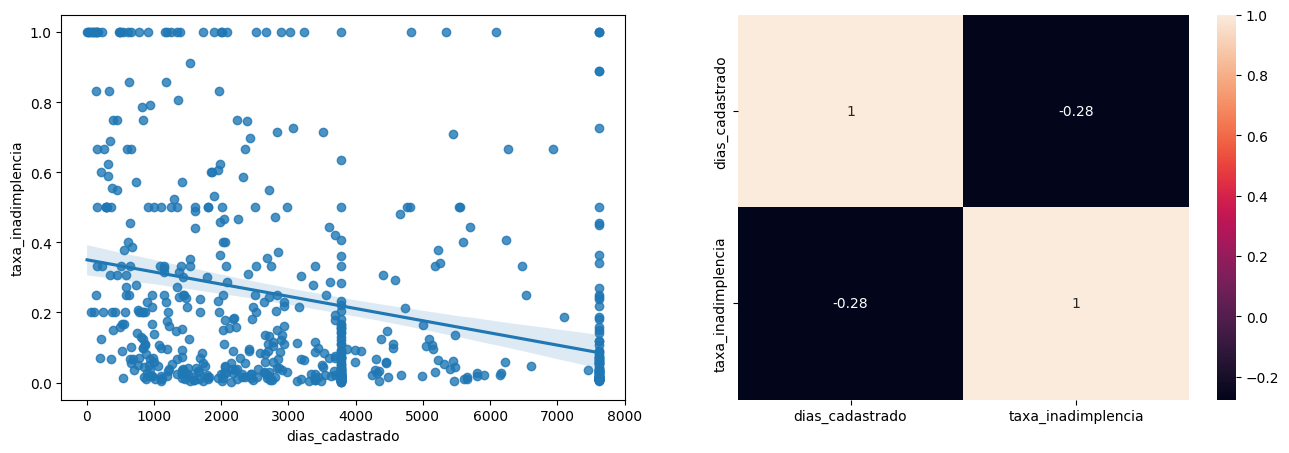

In [211]:
# Dataframe
aux = df4.loc[:, ['dias_cadastrado', 'inadimplente', 'id_cliente']]
aux = aux.groupby(['id_cliente', 'dias_cadastrado', 'inadimplente']).size().reset_index()
aux = aux.rename(columns={0: 'qtde_pedidos'})
aux2 = aux.loc[:, ['id_cliente', 'qtde_pedidos']].groupby('id_cliente').sum().reset_index()
aux2 = aux2.rename(columns={'qtde_pedidos': 'total_pedidos'})
aux = pd.merge(aux, aux2, how='left', on='id_cliente')
aux['taxa_inadimplencia'] = aux['qtde_pedidos']/aux['total_pedidos']
aux = aux.loc[aux['inadimplente']==1, ['dias_cadastrado', 'taxa_inadimplencia']]

# Plot
plt.figure(figsize=[16, 5])
plt.subplot(1, 2, 1)
sns.regplot(x='dias_cadastrado', y='taxa_inadimplencia', data=aux)

plt.subplot(1, 2, 2)
sns.heatmap(aux.corr(method='pearson'), annot=True);

### 9. Quanto maior a renda mensal média da empresa, menor a sua taxa de inadimplência

**VERDADEIRO** Há uma correlação de força média entre a renda mensal média e taxa de inadimplência de modo que quanto maior a renda, menor a taxa.

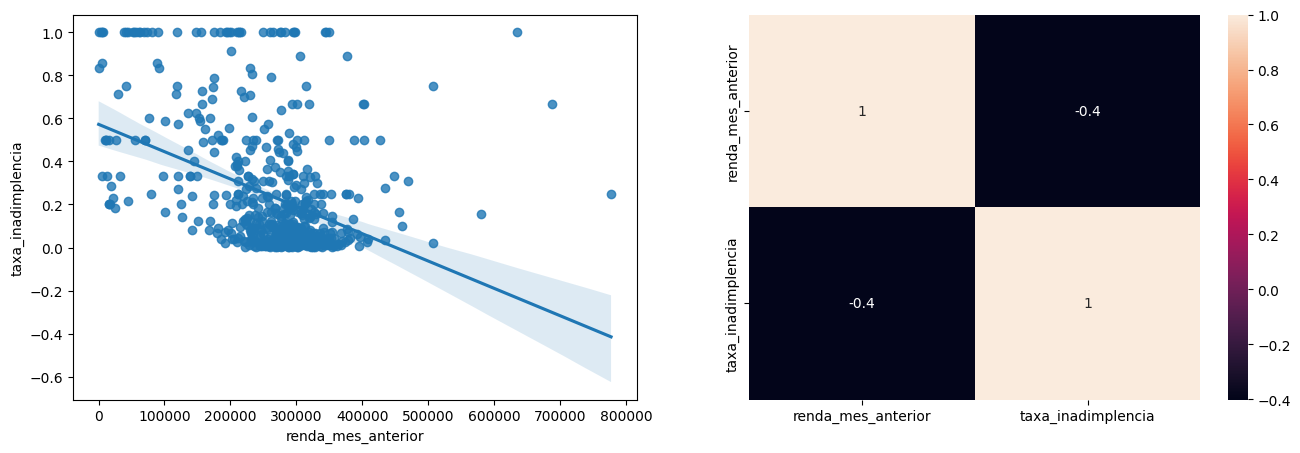

In [212]:
# Dataframe
## Taxa de inadimplência
aux = df4.loc[:, ['inadimplente', 'id_cliente']]
aux = aux.groupby(['id_cliente', 'inadimplente']).size().reset_index()
aux = aux.rename(columns={0: 'qtde_pedidos'})
aux2 = aux.loc[:, ['id_cliente', 'qtde_pedidos']].groupby('id_cliente').sum().reset_index()
aux2 = aux2.rename(columns={'qtde_pedidos': 'total_pedidos'})
aux = pd.merge(aux, aux2, how='left', on='id_cliente')
aux['taxa_inadimplencia'] = aux['qtde_pedidos']/aux['total_pedidos']
aux = aux.loc[aux['inadimplente']==1, ['id_cliente', 'taxa_inadimplencia']]

## Renda mensal média
aux2 = df4.loc[:, ['id_cliente', 'safra_ref', 'renda_mes_anterior']]
aux2 = aux2.drop_duplicates(['id_cliente', 'safra_ref'])
aux2 = aux2.loc[:, ['id_cliente', 'renda_mes_anterior']].groupby('id_cliente').mean().reset_index()

# Merge
aux = pd.merge(aux, aux2, how='left', on='id_cliente')
aux = aux.loc[:, ['renda_mes_anterior', 'taxa_inadimplencia']]

# Plot
plt.figure(figsize=[16, 5])
plt.subplot(1, 2, 1)
sns.regplot(x='renda_mes_anterior', y='taxa_inadimplencia', data=aux)

plt.subplot(1, 2, 2)
sns.heatmap(aux.corr(method='pearson'), annot=True);

### 10. Os registros de inadimplência aumentam com o passar dos meses.

**FALSO** Não há tendência no aumento do registro de inadimplências ao longo dos meses.

C:\Users\faust\anaconda3\envs\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\faust\anaconda3\envs\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\faust\anaconda3\envs\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\faust\anaconda3\envs\venv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Categorica

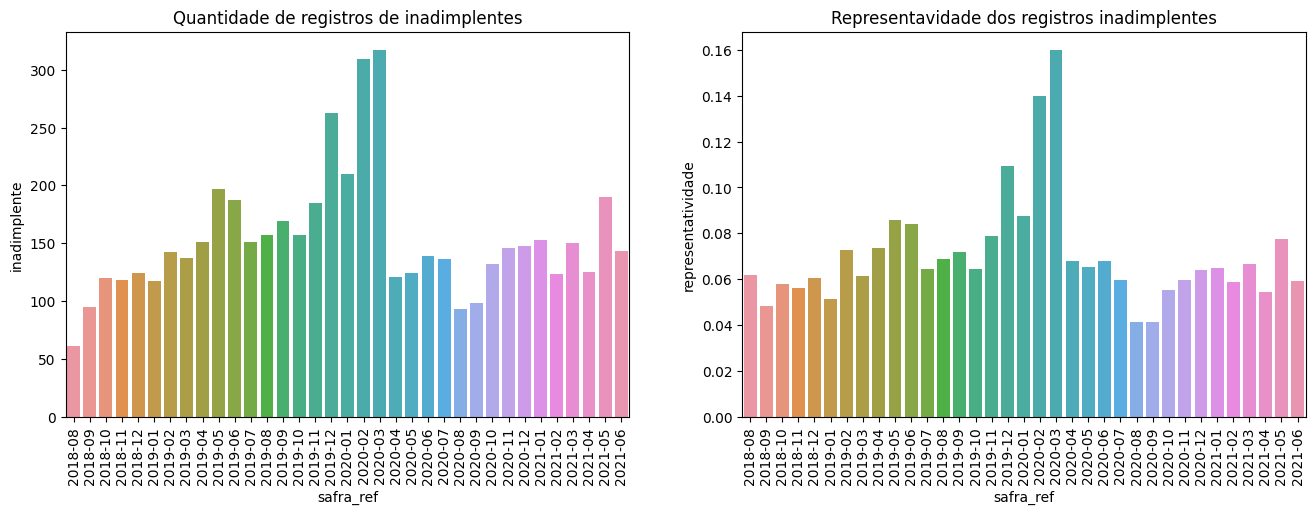

In [213]:
# Dataframe
aux = df4.loc[df4['inadimplente']==1, ['inadimplente', 'safra_ref']].groupby('safra_ref').sum().reset_index()
total_registros = df4.loc[:, ['safra_ref']].groupby('safra_ref').size().reset_index()
total_registros = total_registros.rename(columns={0: 'contagem'})
aux2 = pd.merge(aux, total_registros, how='left', on='safra_ref')
aux2['representatividade'] = aux2['inadimplente']/aux2['contagem']

# Plot
plt.figure(figsize=[16, 5])

plt.subplot(1, 2, 1)
sns.barplot(x='safra_ref', y='inadimplente', data=aux)
plt.xticks(rotation=90)
plt.title('Quantidade de registros de inadimplentes')

plt.subplot(1, 2, 2)
sns.barplot(x='safra_ref', y='representatividade', data=aux2)
plt.xticks(rotation=90)
plt.title('Representavidade dos registros inadimplentes');

## 4.3 - Análise multivariada

### 4.3.1 - Atributos numéricos

**ANÁLISE:** A correlação de **Pearson** (comumente utilizada) mostrou fraquíssimas correlações entre as variáveis, logo as variáveis não possuem relações de linearidade. Nesse caso, decidiu-se utilizar a correlação de **Kendall** (mais apropriada para detectar relações não lineares). Observa-se que a **grande maioria** das variáveis possuem **fracas correlações** entre si.

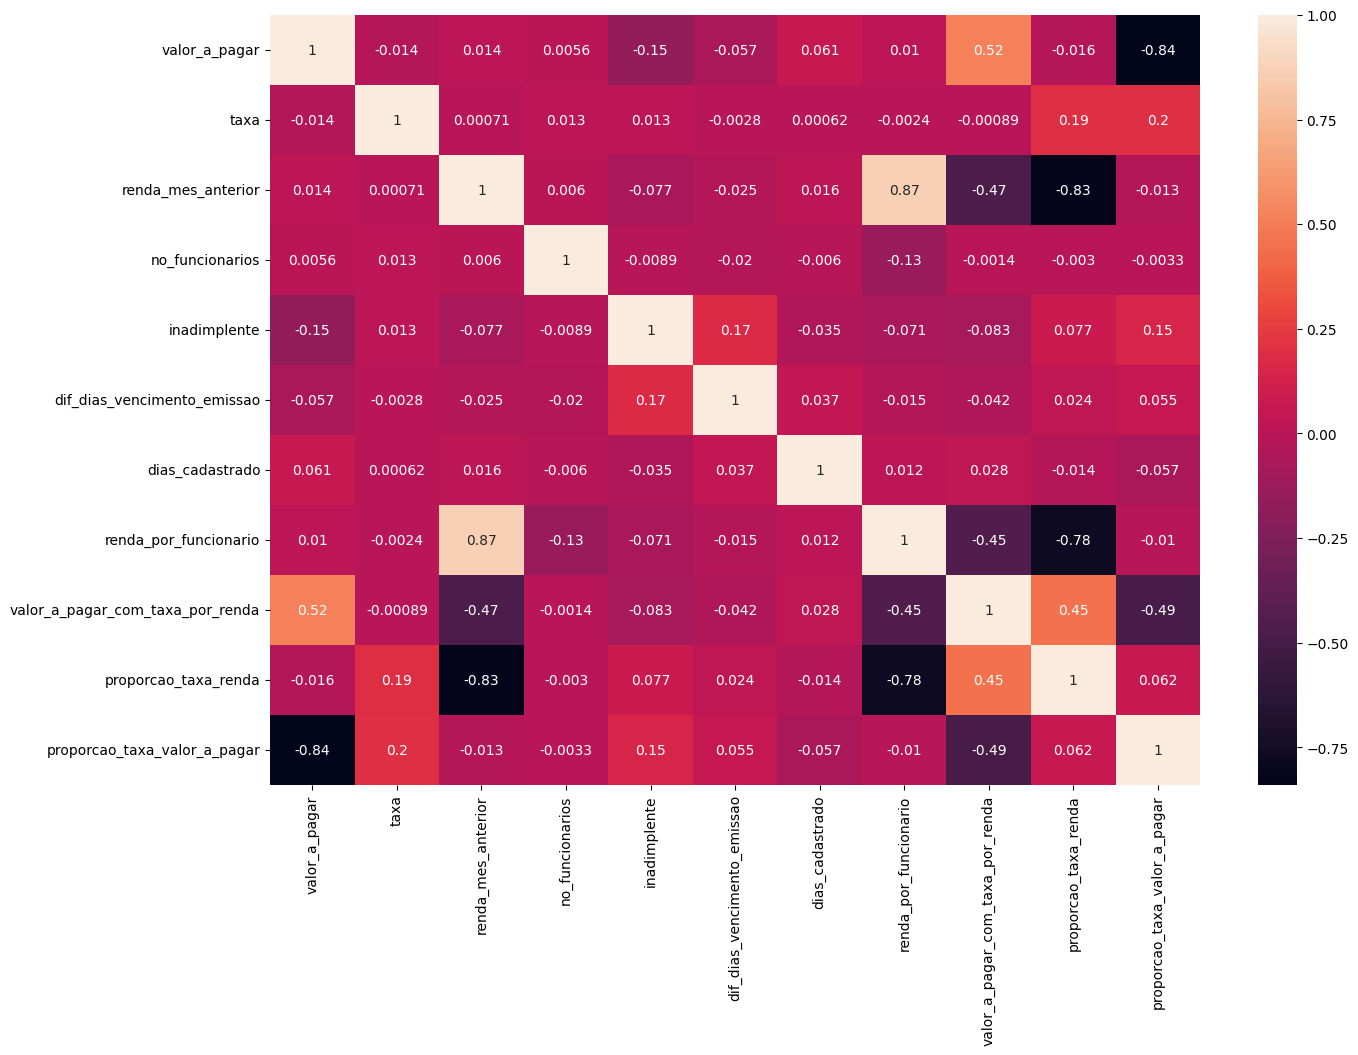

In [214]:
num_attributes = df4.select_dtypes(include=['int64', 'float64'])

plt.figure(figsize=(15, 10))
correlation = num_attributes.corr(method='kendall')
sns.heatmap(correlation, annot=True);

### 4.3.2 - Atributos categóricos

**ANÁLISE:** As variáveis **categóricas** possuem um número maior de correlações **fortes** quando se compara ao caso das variáveis numéricas. Isso pode ser positivo a modelagem dos algoritmos de Machine Learning.

In [215]:
cat_attributes = df3.select_dtypes(exclude=['int64', 'float64'])
cat_attributes_list = cat_attributes.columns.tolist()#.drop('id_cliente', axis=1).columns.tolist()

corr_dict = {}
for i in range(len(cat_attributes_list)):
    corr_list = []
    for j in range(len(cat_attributes_list)):
        ref = cat_attributes_list[i]
        feat = cat_attributes_list[j]
        
        # correlation
        corr = cramer_v(cat_attributes[ref], cat_attributes[feat])
        
        # append a list
        corr_list.append(corr)
    
    # appende a correlation list for each ref attributs
    corr_dict[ref] = corr_list

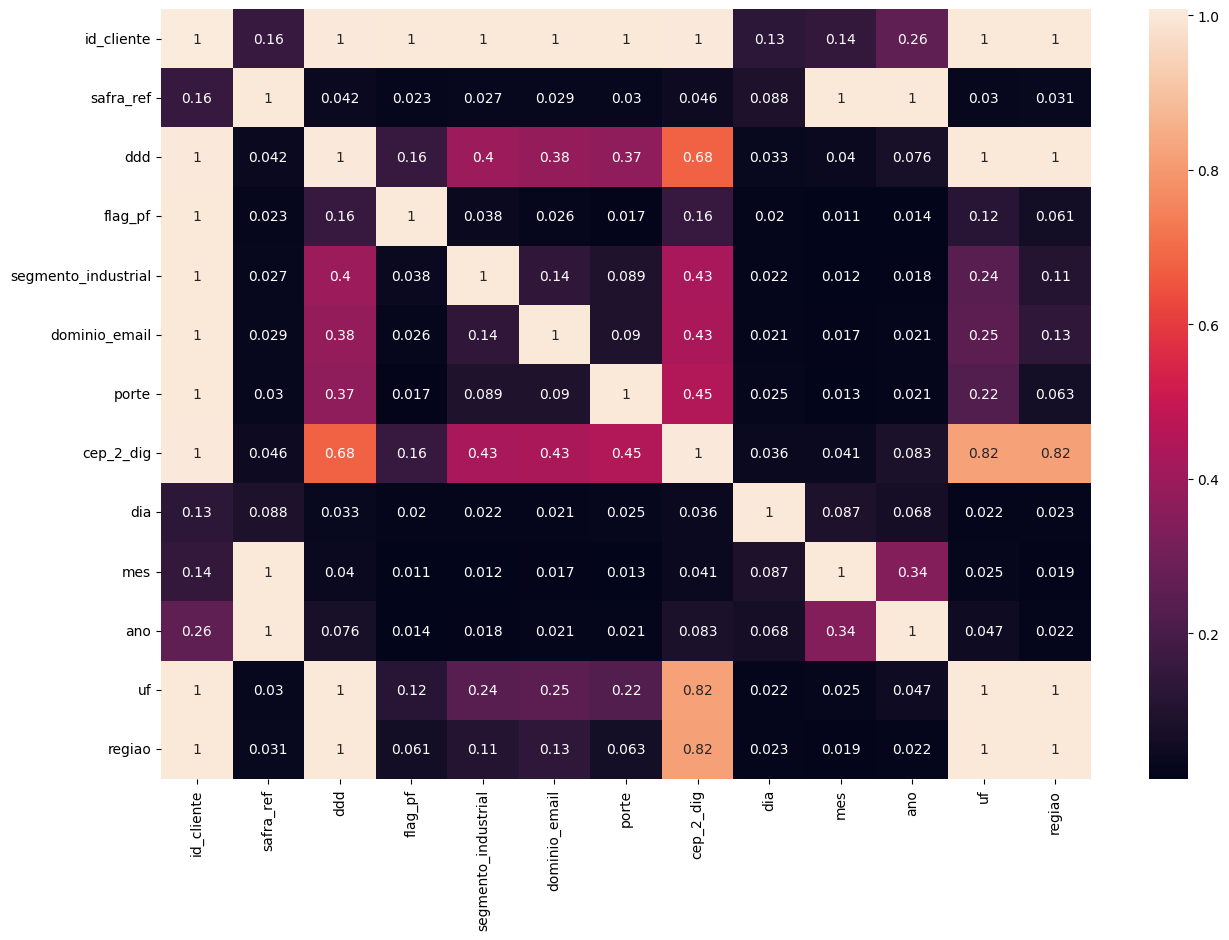

In [216]:
plt.figure(figsize=(15,10))
d = pd.DataFrame(corr_dict)
d = d.set_index(d.columns)
sns.heatmap(d, annot=True);

# 5 - PREPARAÇÃO DOS DADOS

In [230]:
x = df3.copy()

## 5.1 - Encoding

In [231]:
# Label encoder
cols_object_label = ['ddd', 'cep_2_dig', 'uf', 'id_cliente', 'flag_pf', 'segmento_industrial', 'dominio_email', 'porte', 'regiao']
le = pp.LabelEncoder()
for i in cols_object_label:
    x[i] = le.fit_transform(x[i])
    pickle.dump(le, open('parameters/' + i + '.pkl', 'wb'))

In [232]:
# Definição de um dataframe 'Out of time' para validação dos modelos de Machine Learning
df_oot = x.loc[x['safra_ref'].isin(['2021-05', '2021-06']), :].drop('safra_ref', axis=1)

In [233]:
# Dataframe descontando o df 'Out of time'
y = x.loc[~x['safra_ref'].isin(['2021-05', '2021-06']), 'inadimplente']
x = x.loc[~x['safra_ref'].isin(['2021-05', '2021-06']), :].drop(['safra_ref', 'inadimplente'], axis=1)

## 5.1 - Train and test split

In [235]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=42)

## 5.2 - Balanceamento de Classes nos dados de treino

Como a base de dados é bastante desbalanceada é necessário aplicar balanceamento de classe. Para não realizar modificações drásticas na base de dados com povoamento registros com a classe 1, será feito o balanceamento via **Undersampling**.

In [238]:
under_sample = RandomUnderSampler(sampling_strategy=0.3, random_state=42)
X_train, y_train = under_sample.fit_resample(X_train, y_train)

## 5.3 - Rescalling

In [205]:
# Robust Scaler
rs = pp.RobustScaler()
cols_selected = ['valor_a_pagar', 'taxa', 'dif_dias_vencimento_emissao', 'dias_cadastrado', 'valor_a_pagar_com_taxa_por_renda',
                 'proporcao_taxa_renda', 'proporcao_taxa_valor_a_pagar', 'ano', 'renda_mes_anterior', 'no_funcionarios', 
                 'renda_por_funcionario']

for i in cols_selected:
    X_train[i] = rs.fit_transform(X_train[[i]])
    X_test[i] = rs.transform(X_test[[i]])
    df_oot[i] = rs.transform(df_oot[[i]])
    # Salvando as parametrizações
    #pickle.dump(rs, open('parameters/' + i + '.pkl', 'wb'))

## 5.4 - Transformação

In [207]:
# dia
X_train['dia_sin'] = X_train['dia'].apply(lambda x: np.sin(x*2*np.pi/365.25))
X_train['dia_cos'] = X_train['dia'].apply(lambda x: np.cos(x*2*np.pi/365.25))
X_test['dia_sin'] = X_test['dia'].apply(lambda x: np.sin(x*2*np.pi/365.25))
X_test['dia_cos'] = X_test['dia'].apply(lambda x: np.cos(x*2*np.pi/365.25))
df_oot['dia_sin'] = df_oot['dia'].apply(lambda x: np.sin(x*2*np.pi/365.25))
df_oot['dia_cos'] = df_oot['dia'].apply(lambda x: np.cos(x*2*np.pi/365.25))

# mes
X_train['mes_sin'] = X_train['mes'].apply(lambda x: np.sin(x*2*np.pi/12))
X_train['mes_cos'] = X_train['mes'].apply(lambda x: np.cos(x*2*np.pi/12))
X_test['mes_sin'] = X_test['mes'].apply(lambda x: np.sin(x*2*np.pi/12))
X_test['mes_cos'] = X_test['mes'].apply(lambda x: np.cos(x*2*np.pi/12))
df_oot['mes_sin'] = df_oot['mes'].apply(lambda x: np.sin(x*2*np.pi/12))
df_oot['mes_cos'] = df_oot['mes'].apply(lambda x: np.cos(x*2*np.pi/12))

# Drop
X_train.drop(['mes', 'dia'], axis=1, inplace=True)
X_test.drop(['mes', 'dia'], axis=1, inplace=True)
df_oot.drop(['mes', 'dia'], axis=1, inplace=True)